## Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.
 
Таблица **steel.data_arc**
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.
  
Таблица **steel.data_bulk**
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.
  
Таблица **steel.data_bulk_time**
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.
  
Таблица **steel.data_gas**
* key — номер партии;
* gas — объём подаваемого газа.
  
Таблица **steel.data_temp**
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.
  
Таблица **steel.data_wire**
* key — номер партии;
* Wire1 … Wire9 — объём подаваемых проволочных материалов.
  
Таблица **steel.data_wire_time**
* key — номер партии;
* Wire1 … Wire9 — время подачи проволочных материалов.
  
Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подготовка

In [1]:
#!pip3 -q install sqlalchemy
#!pip3 install seaborn
#!pip3  install tensorflow
#!pip3  install torch
#! pip install -q skorch
import os
import sys
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import catboost
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import Adam

from sqlalchemy import inspect, create_engine
from numpy import sqrt

from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVR

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

In [2]:
print('pandas = ',pd.__version__)
print('numpy = ',np.__version__)
try:
    print('tensorflow = ',tf.version.VERSION)
except:
    print('tensorflow not found')

try:
    print('torch = ',torch.__version__)
except:
    print('torch not found')

pandas =  2.3.1
numpy =  2.3.2
tensorflow =  2.18.0
torch not found


In [3]:
print('Python =',sys.version)

Python = 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]


In [4]:
def df_short_view(df): #показывает краткую информацию о таблице
    """
    Args
        df        # датафрейм из которого нужно показать данные.
    Returns 

    """
    print('Размер таблицы:', df.shape)
    print()
    print(df.info())
    print()    
    print(df.isna().sum())
    display(df.head(5))
    return

def df_full_view(df):    
    """
    Args
        df        # датафрейм из которого нужно показать данные.
    Returns 
        
    """
    df_short_view(df)
    print('Количество явных дубликатов:' , df.duplicated().sum())
    print('Количество пропусков:\n', df.isna().sum())
    display(df.describe())
    return

def col_2_date(df, re_pattern, print_info = True):
    """
    Переводит столбцы в формат to_datetime. Имена столбцов передаются маской.
    ARGS

    RETURN
        df # датафрейм с переформатированными столбцами
    """
    bulk_columns = [col for col in df.columns if re_pattern.match(col)]
    
    if print_info == True:
        print(f"Найдены столбцы: {bulk_columns}")

    for column in bulk_columns:
        try:
        # Параметры для обработки различных форматов дат
            df[column] = pd.to_datetime(
                                                df[column], 
                                                errors='coerce',  # преобразует ошибки в NaT
            )
           
            if print_info == True:
                print(f"Столбец '{column}' преобразован")
        except Exception as e:
            print(f"Ошибка в столбце '{column}': {e}")
    

    return df

def col_2_numeric(df, re_pattern, print_info = True):
    """
    Переводит столбцы в формат int или float. Имена столбцов передаются маской.
    ARGS

    RETURN
        df # датафрейм с переформатированными столбцами
    """
    bulk_columns = [col for col in df.columns if re_pattern.match(col)]
    
    if print_info == True:
        print(f"Найдены столбцы: {bulk_columns}")

    for column in bulk_columns:
        try:
        # Параметры для обработки различных форматов дат
            df[column] = pd.to_numeric(
                                                df[column], 
                                                errors='coerce',  # преобразует ошибки в NaT
            )
           
            if print_info == True:
                print(f"Столбец '{column}' преобразован")
        except Exception as e:
            print(f"Ошибка в столбце '{column}': {e}")
    

    return df

In [5]:
def corr_heatmap(df: pd.DataFrame,xl,yh, metod_cor, drop_columns):
        """
        Args ",
            df: pd.DataFrame
            xl: длина графика
            yh: высота графика
            metod_cor:  Method of correlation
                        pearson : standard correlation coefficient
                        kendall : Kendall Tau correlation coefficient
                        spearman : Spearman rank correlation
            drop_columns: колонки которые не попадут на график кореляции
        """ 
        try:
            df = df.drop(columns = drop_columns)
        except:
            df = df
        try:
            df=df.corr(method = metod_cor, numeric_only=True)
        except:
            df=df.corr(method = metod_cor)
        plt.figure(
            figsize=(xl,yh),
    #        dpi= 80\n",
        )
        if metod_cor == 'spearman': 
            plt.title('Матрица корреляции (Спирмен)', fontsize=14)
        if metod_cor == 'pearson': 
            plt.title('Матрица корреляции (Пирсен)', fontsize=14)
        if metod_cor == 'kendall': 
            plt.title('Матрица корреляции (Кенделл)', fontsize=14)
        sns.heatmap(
    #        df.corr(),
     #cmap='coolwarm' ('bwr', 'seismic'),
            df,
            xticklabels=df.columns,
            yticklabels=df.columns, 
            cmap='RdYlGn',
#            cmap='coolwarm' ,#('bwr', 'seismic'),
            center=0,
            annot=True,
    #        robust=True,
        )
        return


In [6]:
def get_table_as_dataframe(table_name):
    """
    Получить таблицу как DataFrame
    """
    try:
        df = pd.read_sql_table(table_name, con=engine)
        print(f"\nТаблица '{table_name}':")
        return df
    except Exception as e:
        print(f"Ошибка при чтении таблицы {table_name}: {e}")
        return None

In [7]:
def space_2_low_line (df):
    """
    Проеобразует пробелы между словами в названии столбцов в подчёркивания.
    ARGS
        df - исходный датафрейм.
    RETURN
        df - с исправленными названиями столбцов
    """
    df.columns = (
        df.columns
        .str.strip()  # удаляем пробелы по краям
        .str.lower()  # приводим к нижнему регистру
        .str.replace(r'[\s\/\\]+', '_', regex=True)  # заменяем пробелы и слэши
        .str.replace(r'_+', '_', regex=True)  # удаляем повторяющиеся подчёркивания
        .str.strip('_')  # удаляем подчёркивания по краям
    )
    return df

In [8]:
def explore_database():
    """Исследовать всю базу данных"""
    inspector = inspect(engine)
    
    for table_name in inspector.get_table_names():
        print(f"\n{'='*50}")
        print(f"ТАБЛИЦА: {table_name}")
        print(f"{'='*50}")
        
        # Получаем информацию о колонках
        columns = inspector.get_columns(table_name)
        print("Колонки:")
        for column in columns:
            print(f"  - {column['name']}: {column['type']}")
        
        # Получаем первые 5 строк
        try:
            df = pd.read_sql_table(table_name, con=engine)
            print(f"\nПервые 5 строк:")
            print(df.head())
            
            print(f"\nОбщая информация:")
            print(f"Количество строк: {len(df)}")
            print(f"Количество колонок: {len(df.columns)}")
            
        except Exception as e:
            print(f"Не удалось прочитать данные: {e}")


In [9]:
def hist_and_box_with_stats(df, column, title, xlabel, bins):
    """
    df     - данные
    column - признак по которому строятся графики
    title  - общий заголовок
    xlabel - подпись под осью Х
    bins   - количество бинов для гистограммы
    """
    # Вычислим основные статистики
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]
    
    # Создадим сетку графиков: 1 строка и 2 столбца
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(f"{title}", fontsize=18)
    
    # Гистограмма с KDE
    sns.histplot(df[column], bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    # Линии для среднего, медианы и моды
    ax[0].axvline(mean, color='green', linestyle='--', label=f'Среднее = {mean:.3f}')
    ax[0].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.3f}')
    ax[0].axvline(mode, color='blue', linestyle='-', label=f'Мода = {mode:.3f}')
    ax[0].legend()

    # Диаграмма размаха (boxplot)
    sns.boxplot(x=df[column], ax=ax[1])
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='red', linestyle='-.', label=f'Медиана = {median:.3f}')
    ax[1].grid(True)
    ax[1].legend()

    # Подгоним графики
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [10]:
def calc_percent_of_zero(df):
    """
    выводит % записей =0 по каждому столбцу
    """
    for col in df.columns:
        try:
            percent = len(df.loc[df[col] == 0])/len(df[col]) * 100
            print('В столбце', col , 'пустыми являются ' , round(percent, 2),'% записей')    
        except:
            print('Cтолбец', col , 'не обработан')
    return

def graph_batch (df,column_list,exception=0):
    """
    Функция выводит графики для всех столбцов переданных списком.
    ARGS
        df - исходный набор данных
        column_list - список столбцов которые надо показать
        exception - значения которые надо отбросить при построении графика. По умолчанию = 0.
    RETURN
    """
    for col in column_list:
        hist_and_box_with_stats(
            df.loc[df[col] !=exception],
            #df, 
            col,
            f'распределение значений {col}', 
            col,
            30
        )
    return

In [11]:
def delta_calculation(df, columns, base_column):
    """
    """
    for bulk_col in columns:
    # Вычисляем разницу в секундах
        diff_col_name = f'{bulk_col}_diff'
        df[diff_col_name] = (df[bulk_col] - df[base_column]).dt.total_seconds()
    
    # Заменяем NaT на 0
        df[diff_col_name] = df[diff_col_name].fillna(0)
    
        print(f"Создан столбец {diff_col_name}")
    return df

In [12]:
def get_feature_importance(model, feature_names):
    """Получить важность признаков для различных типов моделей"""
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based модели
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Линейные модели
        importance = np.abs(model.coef_[0])
    elif hasattr(model, 'steps') or hasattr(model, 'named_steps'):
        # Pipeline - пытаемся получить финальный estimator
        try:
            final_estimator = model.named_steps[list(model.named_steps.keys())[-1]]
            return get_feature_importance(final_estimator, feature_names)
        except:
            return None
    else:
        print("Модель не поддерживает feature importance")
        return None
    
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)


Определим константы

In [13]:
RANDOM_STATE = 42
iter_num = 15    # Сколько шагов будет делать RandomizedSearchCV для определения лучшей модели.
kfold = 5        # На сколько частей будет делиться  
eps = 1500     # количество эпох обучения нейросети

## Получение данных

In [14]:
path_to_db = 'ds-plus-final.db'

In [15]:
if os.path.isfile(path_to_db):
    print("Файл существует")
else:
    print("Файл не существует")
    print('Скачаем файл')
    !wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 
    

Файл существует


### Настраиваем подключение к базе

In [16]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [17]:
#path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 


Посмотрим список таблиц в базе данных

In [18]:
inspector = inspect(engine)
tables = inspector.get_table_names()
print(tables)

['contract', 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time', 'internet', 'personal', 'phone']


### Посмотрим на таблицы перед загрузкой

In [19]:
# Запуск исследования базы данных
explore_database()


ТАБЛИЦА: contract
Колонки:
  - customerID: TEXT
  - BeginDate: TEXT
  - EndDate: TEXT
  - Type: TEXT
  - PaperlessBilling: TEXT
  - PaymentMethod: TEXT
  - MonthlyCharges: TEXT
  - TotalCharges: TEXT

Первые 5 строк:
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  
0           Electronic check          29.85        31.04  
1               Mailed check          56.95      2071.84  
2               Mailed check          53.85       226.17  
3  Bank transfer (automatic)           42.3       1960.6  
4           Electronic check           70.7        353.5  

Общая 

Слишком большого количества записей не наблюдается, будем качать.

### Получим данные

In [20]:
# Проверьте какие методы доступны у вашего engine
print("Доступные методы:")
print([method for method in dir(engine) if not method.startswith('_')])

# Проверьте тип engine
print(f"Тип engine: {type(engine)}")

Доступные методы:
['begin', 'clear_compiled_cache', 'connect', 'dialect', 'dispatch', 'dispose', 'driver', 'echo', 'engine', 'execution_options', 'get_execution_options', 'hide_parameters', 'logger', 'logging_name', 'name', 'pool', 'raw_connection', 'update_execution_options', 'url']
Тип engine: <class 'sqlalchemy.engine.base.Engine'>


In [21]:
df_data_arc = get_table_as_dataframe('data_arc')
df_data_bulk = get_table_as_dataframe('data_bulk')
df_data_bulk_time = get_table_as_dataframe('data_bulk_time')
df_data_gas = get_table_as_dataframe('data_gas')
df_data_temp = get_table_as_dataframe('data_temp')
df_data_wire = get_table_as_dataframe('data_wire')
df_data_wire_time = get_table_as_dataframe('data_wire_time')


Таблица 'data_arc':

Таблица 'data_bulk':

Таблица 'data_bulk_time':

Таблица 'data_gas':

Таблица 'data_temp':

Таблица 'data_wire':

Таблица 'data_wire_time':


### Посмотрим на данные

#### Посмотрим на data_arc

Посмотрим краткое описание полученного набора данных.

In [22]:
df_short_view(df_data_arc)

Размер таблицы: (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [23]:
df_data_arc = space_2_low_line(df_data_arc)

In [24]:
df_short_view(df_data_arc)

Размер таблицы: (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64


key начало_нагрева_дугой  конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Приведём время к нужному формату хранения

In [25]:
re_pattern = re.compile(r'^\w+_нагрева_дугой')
df_data_arc = col_2_date(
                                df_data_arc, 
                                re_pattern,
                                print_info = False #
)

In [26]:
df_short_view(df_data_arc)

Размер таблицы: (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64


key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Получено 14876 записей. Количество столбцов и их содержание соответсвует описанию. Время преобразовано в формат datetime64.

#### Посмотрим на data_bulk

Посмотрим краткое описание полученного набора данных.

In [27]:
df_short_view(df_data_bulk)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB
None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     255

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1     NaN     NaN     NaN    43.0   None   None   None   None   None   
1    2     NaN     NaN     NaN    73.0   None   None   None   None   None   
2    3     NaN     NaN     NaN    34.0   None   None   None   None   None   
3    4     NaN     NaN     NaN    81.0   None   None   None   None   None   
4    5     NaN     NaN     NaN    78.0   None   None   None   None   None   

  Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
0    None    None   206.0    None   150.0   154.0  
1    None    None   206.0    None   149.0   154.0  
2    None    None   205.0    None   152.0   153.0  
3    None    None   207.0    None   153.0   154.0  
4    None    None   203.0    None   151.0   152.0

Приведём названия столбцов к единому виду: заменим пробелы между словами на подчёркивания и сделаем все буквы в нижнего регистра.

In [28]:
df_data_bulk = space_2_low_line(df_data_bulk)

Приведём числовые столбцы к числовому формату.

In [29]:
re_pattern = re.compile(r'bulk_\d+')
df_data_bulk = col_2_numeric(
                                df_data_bulk, 
                                re_pattern,
                                print_info = False #
)

In [30]:
df_short_view(df_data_bulk)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
None

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7    

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

Получено 3129 записей данных об объёме сыпучих материалов. Количество столбцов и их содержание соответсвует описанию. 

#### Посмотрим на data_bulk_time

Посмотрим краткое описание полученного набора данных.

In [31]:
df_short_view(df_data_bulk_time)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1   None   None   None  2019-05-03 11:28:48   None   None   None   None   
1    2   None   None   None  2019-05-03 11:36:50   None   None   None   None   
2    3   None   None   None  2019-05-03 12:32:39   None   None   None   None   
3    4   None   None   None  2019-05-03 12:43:22   None   None   None   None   
4    5   None   None   None  2019-05-03 13:30:47   None   None   None   None   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0   None    None    None  2019-05-03 11:24:31    None  2019-05-03 11:14:50   
1   None    None    None  2019-05-03 11:53:30    None  2019-05-03 11:48:37   
2   None    None    None  2019-05-03 12:27:13    None  2019-05-03 12:21:01   
3   None    None    None  2019-05-03 12:58:00    None  2019-05-03 12:51:11   
4   None    None    None  2019-05-03 13:30:47    None  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Приведём названия столбцов к единому виду: заменим пробелы между словами на подчёркивания и сделаем все буквы в нижнего регистра.

In [32]:
df_data_bulk_time = space_2_low_line(df_data_bulk_time)

Приведём время к нужному формату хранения

In [33]:
re_pattern = re.compile(r'bulk_\d+')
df_data_bulk_time = col_2_date(
                                df_data_bulk_time, 
                                re_pattern,
                                print_info = False #
)

In [34]:
df_short_view(df_data_bulk_time)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_9 bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

Получено 3129 записей о времени подачи сыпучих материалов. Количество столбцов и их содержание соответсвует описанию. Много пропусков.
Все столбцы с датой преобразованы в формат datetime64.

#### Посмотрим на data_gas

Посмотрим краткое описание полученного набора данных.

In [35]:
df_short_view(df_data_gas)

Размер таблицы: (3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

key      0
Газ 1    0
dtype: int64


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Приведём названия столбцов к единому виду: заменим пробелы между словами на подчёркивания и сделаем все буквы в нижнего регистра.

In [36]:
df_data_gas = space_2_low_line(df_data_gas)

Получено 3129 записей о продувке сплава газом. Количество столбцов и их содержание соответсвует описанию. 

#### Посмотрим на data_temp

Посмотрим краткое описание полученного набора данных.

In [37]:
df_short_view(df_data_temp)

Размер таблицы: (18092, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB
None

key                0
Время замера       0
Температура     3427
dtype: int64


key         Время замера Температура
0    1  2019-05-03 11:02:04      1571.0
1    1  2019-05-03 11:07:18      1604.0
2    1  2019-05-03 11:11:34      1618.0
3    1  2019-05-03 11:18:04      1601.0
4    1  2019-05-03 11:25:59      1606.0

In [38]:
df_data_temp = space_2_low_line(df_data_temp)

Приведём числовой признак к числовому формату хранения, а дату запишем в формате datetime.

In [39]:
df_data_temp['время_замера'] = pd.to_datetime(df_data_temp['время_замера'])
df_data_temp['температура'] = pd.to_numeric(df_data_temp['температура'], errors='coerce')

In [40]:
df_short_view(df_data_temp)

Размер таблицы: (18092, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None

key                0
время_замера       0
температура     3427
dtype: int64


key        время_замера  температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

Получено 18092 записей об измерениях температуры. Количество столбцов и их содержание соответсвует описанию. 

#### Посмотрим на data_wire

In [41]:
df_short_view(df_data_wire)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB
None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


key     Wire 1   Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  60.059998     None   None   None   None   None   None   None   None
1    2  96.052315     None   None   None   None   None   None   None   None
2    3  91.160157     None   None   None   None   None   None   None   None
3    4  89.063515     None   None   None   None   None   None   None   None
4    5  89.238236  9.11456   None   None   None   None   None   None   None

Приведём названия столбцов к единому виду: заменим пробелы между словами на подчёркивания и сделаем все буквы в нижнего регистра.

In [42]:
df_data_wire = space_2_low_line(df_data_wire)

Преобразуем столбцы из object в numeric

In [43]:
re_pattern = re.compile(r'wire_\d+')
df_data_wire = col_2_numeric(
                                df_data_wire, 
                                re_pattern,
                                print_info = False #
)

In [44]:
df_short_view(df_data_wire)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

Получено 3081 записей об объёме проволочных материалов. Количество столбцов и их содержание соответсвует описанию. Признаки приведены к числовому формату хранения.

#### Посмотрим на data_wire_time

In [45]:
df_short_view(df_data_wire_time)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                 None   None   None   None   None   
1    2  2019-05-03 11:36:50                 None   None   None   None   None   
2    3  2019-05-03 12:11:46                 None   None   None   None   None   
3    4  2019-05-03 12:43:22                 None   None   None   None   None   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34   None   None   None   None   

  Wire 7 Wire 8 Wire 9  
0   None   None   None  
1   None   None   None  
2   None   None   None  
3   None   None   None  
4   None   None   None

Приведём названия столбцов к единому виду: заменим пробелы между словами на подчёркивания и сделаем все буквы в нижнего регистра.

In [46]:
df_data_wire_time = space_2_low_line(df_data_wire_time)

Приведём время к нужному формату хранения

In [47]:
re_pattern = re.compile(r'wire_\d+')
df_data_wire_time = col_2_date(
                                df_data_wire_time, 
                                re_pattern,
                                print_info = True #
)

Найдены столбцы: ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
Столбец 'wire_1' преобразован
Столбец 'wire_2' преобразован
Столбец 'wire_3' преобразован
Столбец 'wire_4' преобразован
Столбец 'wire_5' преобразован
Столбец 'wire_6' преобразован
Столбец 'wire_7' преобразован
Столбец 'wire_8' преобразован
Столбец 'wire_9' преобразован


In [48]:

df_short_view(df_data_wire_time)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key              wire_1              wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  wire_7 wire_8 wire_9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

Получено 3081 записей о времени подачи сыпучих материалов. Количество столбцов и их содержание соответсвует описанию. Много пропусков. Все столбцы с датой преобразованы в формат datetime64.

### Итоговый результат шага загрузки данных

Загружены все 7 заявленных таблиц:
* data_arc — данные об электродах;
* data_bulk — данные об объёме сыпучих материалов;
* data_bulk_time — данные о времени подачи сыпучих материалов;
* data_gas — данные о продувке сплава газом;
* data_temp — данные об измерениях температуры;
* data_wire — данные об объёме проволочных материалов;
* data_wire_time — данные о времени подачи проволочных материалов.

У всех таблиц имена столбцов приведены к единому формату:
* пробелы заменены на подчёркивания
* буквы приведены к нижнему регистру.
* время записанно в формате datetime64
* числовые данные сохранены в формате float64


## Исследовательский анализ и предобработка данных

### Проанализируем  данные об электродах - df_data_arc

#### Проверим на пропуски

In [49]:
df_data_arc.isnull().sum()

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64

Пропусков значений нет.

Посмотрим краткий анализ полученных данных.

In [50]:
df_short_view(df_data_arc)

Размер таблицы: (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64


key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Полных дублей нет. Пропусков в данных нет.

#### Рассмотрим столбец Key.

Столбец key содержит в себе номер партии. Содержит записи от 1 до 3241

In [51]:
print('Kоличество уникальных значений:', len(df_data_arc['key'].unique()))

Kоличество уникальных значений: 3214


Уникальных номеров партии 3214. Это меньше чем записанные 3241. Значит некоторые номера партий пропущены.

In [52]:
df_data_arc.groupby('key')['key'].count().value_counts()

key
4     892
5     759
3     520
6     490
7     205
2     174
8      84
1      39
9      28
10      9
11      5
12      3
13      2
15      2
16      1
14      1
Name: count, dtype: int64

Видно что номера партий чаще всего повторяются от 1 до 9 раз. 10 и больше раз повторяются очень редко.

У нас есть время начала работы разогрева электродами, и время окончания. Найдём длительность этого интервала для каждой записи.

In [53]:
df_data_arc['time_delta_heat'] = (df_data_arc['конец_нагрева_дугой'] - df_data_arc['начало_нагрева_дугой']).dt.total_seconds().astype('int32')

In [54]:
df_data_arc['time_delta_heat'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_delta_heat, dtype: float64

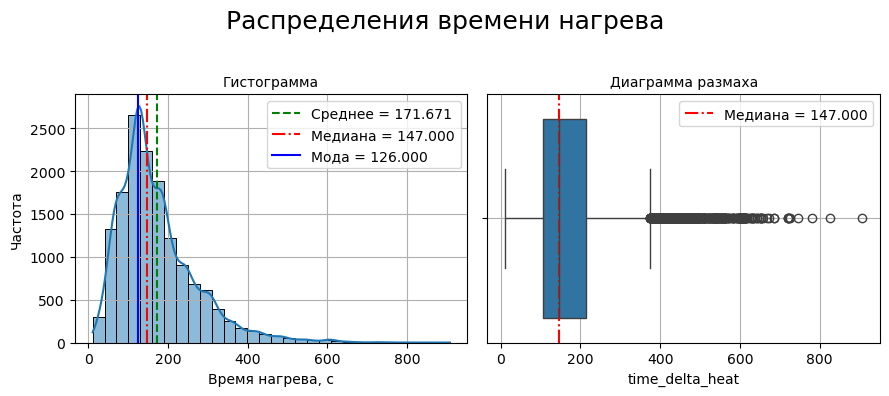

In [55]:
hist_and_box_with_stats(
    df_data_arc, 
    'time_delta_heat',
    'Распределения времени нагрева', 
    'Время нагрева, с',
    30
)

Отрицательных и =0 значений  не видно, значит в нашем наборе данных время окончание процесса всегда больше чем время начала процесса. Это значит что явных ошибок в данных пока не выявлено. Так же видно что четверть временных интервалов имеют длительность 150-200 секунд.

#### Рассмотрим столбец активная_мощность.

In [56]:
df_data_arc['активная_мощность'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: активная_мощность, dtype: float64

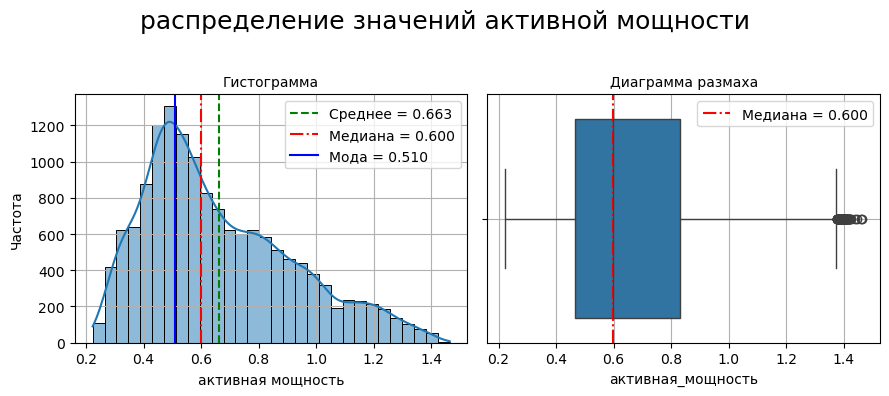

In [57]:
hist_and_box_with_stats(
    df_data_arc, 
    'активная_мощность',
    'распределение значений активной мощности', 
    'активная мощность',
    30
)

Отрицательных значений нет. Все значений лежат в интервале от 0.22 до 1.47. Половина значений лежит в интервале 0.46-0.83

#### Рассмотрим столбец реактивная_мощность.

In [58]:
df_data_arc['реактивная_мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

Отрицательное значение мощности настораживает. Посмотрим количество таких записей.

In [59]:
df_data_arc.loc[df_data_arc['реактивная_мощность'] < 0]

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
9780  2116  2019-07-28 02:22:08 2019-07-28 02:23:57           0.705344   

      реактивная_мощность  time_delta_heat  
9780          -715.479924              109

Всего одна запись.<br/>
Положительная реактивная мощность соответствует индуктивной нагрузке (потребление), тогда как отрицательная — емкостной (производство или отдача реактивной мощности в сеть). В нашем случае нагревательные элементы отдавать в сеть не могут, значит будем считать это ошибкой ввода данных. Попробуем исправить это значение применив коэффициент между активной и реактивной мощностью. Возьмём медиану, она не так чувствительна к аномалиям.

In [60]:
coeff_power = (df_data_arc['реактивная_мощность'] / df_data_arc['активная_мощность']).median()
print(coeff_power)

0.724754106373317


Применим полученный коэффициент к известному значению активной можности для исправления значения реактивной мощности.

In [61]:
df_data_arc.loc[df_data_arc['реактивная_мощность'] < 0, 'реактивная_мощность'] = df_data_arc['активная_мощность']*coeff_power

In [62]:
df_data_arc['реактивная_мощность'].describe()

count    14876.000000
mean         0.487117
std          0.197606
min          0.153777
25%          0.337192
50%          0.441667
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

Стало значительно лучше. Построим графики.

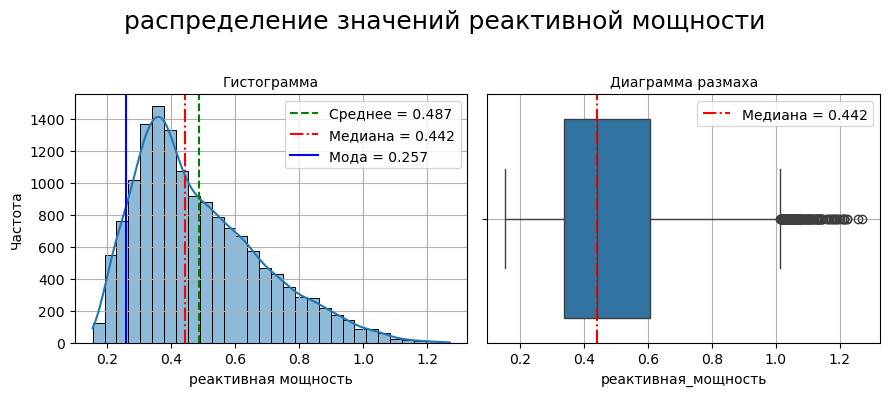

In [63]:
hist_and_box_with_stats(
    df_data_arc, 
    'реактивная_мощность',
    'распределение значений реактивной мощности', 
    'реактивная мощность',
    30
)

Отрицательных значений нет. Все значений лежат в интервале от 0.15 до 1.27. Половина значений лежит в интервале 0.33-0.6

#### Добавим несколько дополнительных столбцов

##### Общая мощность

Общая мощность расчитывается по формуле :
$$
общая мощность = \sqrt{активная мощность^2 + реактивная мощность^2 }
$$

In [64]:
df_data_arc['common_power'] = sqrt (
                                    df_data_arc['активная_мощность']**2
                                    +
                                    df_data_arc['реактивная_мощность']**2    
)

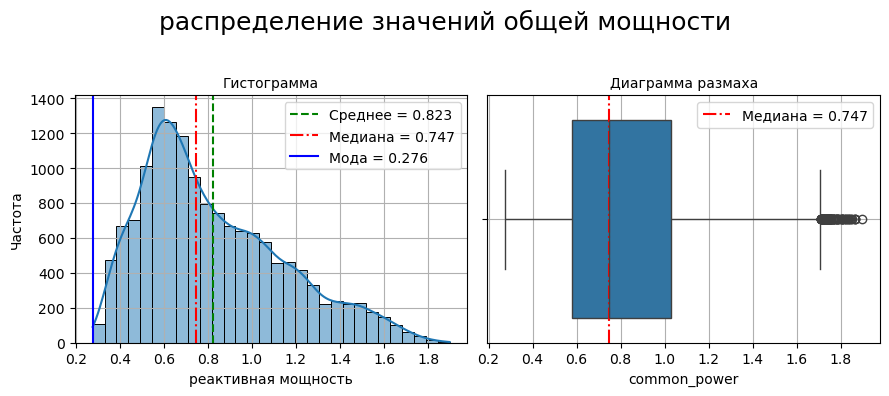

In [65]:
hist_and_box_with_stats(
    df_data_arc, 
    'common_power',
    'распределение значений общей мощности', 
    'реактивная мощность',
    30
)

##### Коэффициент мощности

In [66]:
df_data_arc['coeff_power'] = (df_data_arc['реактивная_мощность'] / df_data_arc['активная_мощность'])

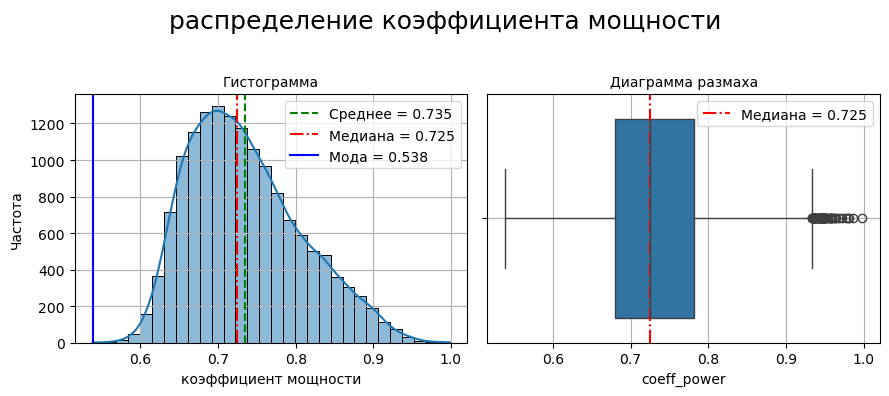

In [67]:
hist_and_box_with_stats(
    df_data_arc, 
    'coeff_power',
    'распределение коэффициента мощности', 
    'коэффициент мощности',
    30
)

Коэффициент мощности не зафиксирован. Скорее всего он меняется в зависимости от электромагнитных и индукционных свойств партии металла. Например может зависить от количества металла в выплавке, от количества и типа легирующих добавок, температуры и пр.

##### Добавим мощности

In [68]:
df_data_arc['total_energy'] = (df_data_arc['common_power'] * df_data_arc['time_delta_heat'])
df_data_arc['active_energy'] = (df_data_arc['активная_мощность'] * df_data_arc['time_delta_heat'])
df_data_arc['reactive_energy'] = (df_data_arc['реактивная_мощность'] * df_data_arc['time_delta_heat'])

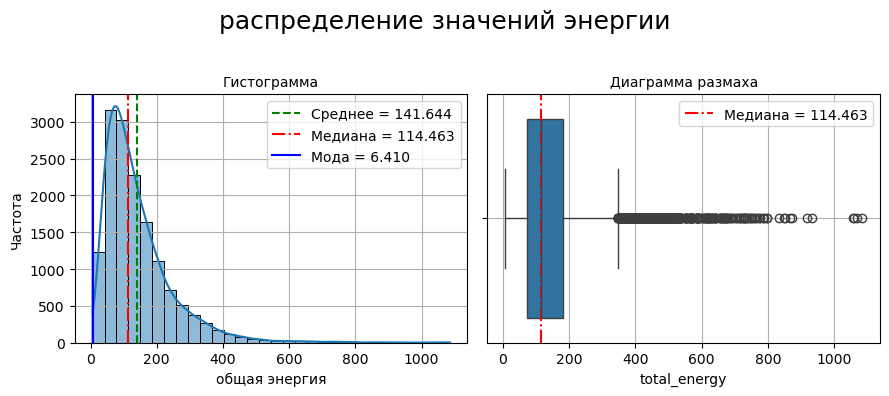

In [69]:
hist_and_box_with_stats(
    df_data_arc, 
    'total_energy',
    'распределение значений энергии', 
    'общая энергия',
    30
)

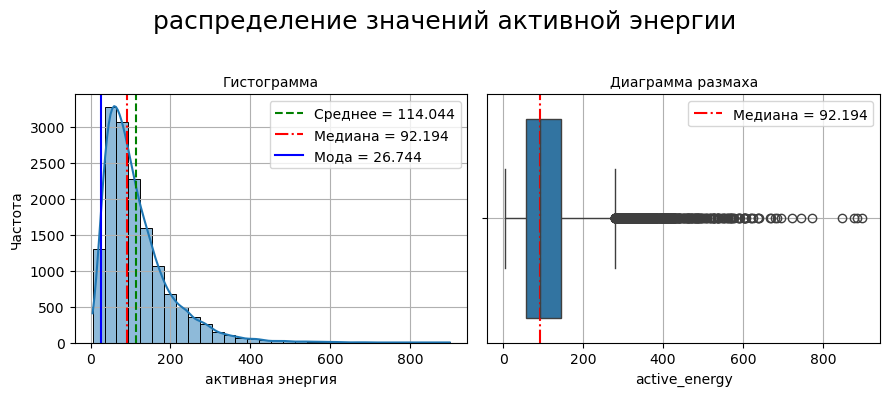

In [70]:
hist_and_box_with_stats(
    df_data_arc, 
    'active_energy',
    'распределение значений активной энергии', 
    'активная энергия',
    30
)

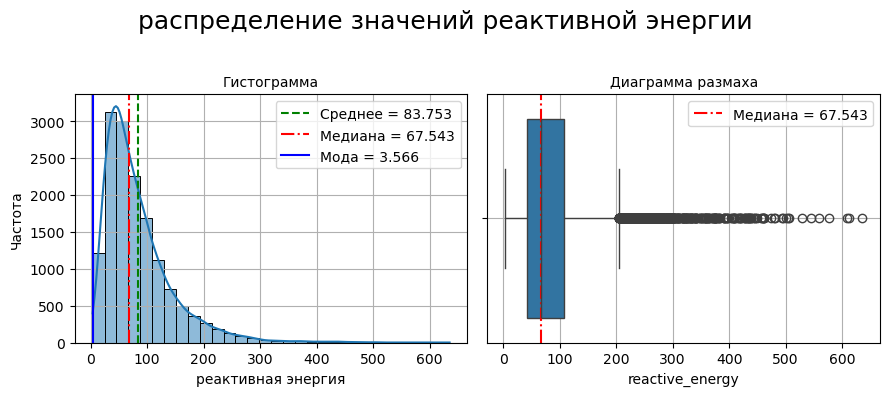

In [71]:
hist_and_box_with_stats(
    df_data_arc, 
    'reactive_energy',
    'распределение значений реактивной энергии', 
    'реактивная энергия',
    30
)

In [72]:
df_full_view(df_data_arc)

Размер таблицы: (14876, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
 5   time_delta_heat       14876 non-null  int32         
 6   common_power          14876 non-null  float64       
 7   coeff_power           14876 non-null  float64       
 8   total_energy          14876 non-null  float64       
 9   active_energy         14876 non-null  float64       
 10  reactive_energy       14876 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int32(1), int64(1)
memory usage: 1.2 MB
None

key                    

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   реактивная_мощность  time_delta_heat  common_power  coeff_power  \
0             0.211253              228      0.371123     0.692338   
1             0.477438              185      0.902319     0.623566   
2             0.430460              172      0.722536     0.741772   
3             0.379979              365      0.642824     0.732848   
4             0.643691              148      1.079934     0.742321   

   total_energy  active_energy  reactive_energy  
0     84.616003      69.569640        48.165684  
1    166.928978     141.646730        88.326030  
2    124.276277      99.813836        74.039120  
3    234.630603     189.251040       138.692335  
4    159.830252     128.335684        95.266268

Количество явных дубликатов: 0
Количество пропусков:
 key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
time_delta_heat         0
common_power            0
coeff_power             0
total_energy            0
active_energy           0
reactive_energy         0
dtype: int64


key           начало_нагрева_дугой  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                 конец_нагрева_дугой  активная_мощность  реактивная_мощность  \
count                          14876       14876.000000         14876.000000   
mean   2019-07-05 12:28:43.592027392           0.662752             0.487117   
min              2019-05-03 11:06:02           0.223120             0.153777   
25%              2019-06-03 23:21:35           0.467115             0.337192   
50%              2019-07-03 01:35:13           0.599587             0.441667   
75%              2019-08-07 22:56:47           0.830070             0.608201   
max              2019-09-06 17:26:15           1.463773             1.270284   
std                              NaN           0.258885             0.197606   

       time_delta_heat  common_power   coeff_power  total_energy  \
count     14876.000000  14876.000000  14876.000000  14876.000000   
mean        171.670946      0.823388      0.734923    141.643860   
min          11.000000      0.275718      0.538375      6.409531   
25%         107.000000      0.578847      0.679710     71.158372   
50%         147.000000      0.746591      0.724756    114.462623   
75%         214.000000      1.030390      0.781162    181.345716   
max         907.000000      1.898158      0.998261   1084.729420   
std          98.186803      0.323459      0.072415    103.197618   

       active_energy  reactive_energy  
count   14876.000000     14876.000000  
mean      114.044276        83.752967  
min         5.246505         3.566134  
25%        57.376903        41.885407  
50%        92.194117        67.542504  
75%       145.983547       106.972660  
max       898.200876       635.262558  
std        83.006059        61.660946

#### Агрегируем по признаку KEY

Агрегируем полученные данные по ключу (key). На данном этапе оставим время начала и время окончания обработки партии электродами, взяв в качестве начального времени - начало первого этапа обработки, а в качестве  конечного времени -  окончание последнего этапа обработки, добавим также общее количество этапов обработки (count_heat).

In [73]:
agg_func_data_arc = {
    'key' : 'count',                     # количество записей связанных с одной выплавеой
    'начало_нагрева_дугой' : 'first',    # начало нагрева 
    'конец_нагрева_дугой' : 'last',      # завершение нагрева
    'активная_мощность' : 'mean',        # средняя подаваяемая активная мощность
    'реактивная_мощность' : 'mean',      # средняя реактивная мощность
    'time_delta_heat' : 'sum',           # 
    'common_power' : 'sum', # 'mean',    # 
    'coeff_power' : 'mean',
    'total_energy' : 'sum',
 
}

In [74]:
df_data_arc_grouped = df_data_arc.groupby('key').agg(agg_func_data_arc).rename(columns={'key':'count_heat'})
df_data_arc_grouped['time_delta_heat_mean'] = df_data_arc.groupby('key')['time_delta_heat'].mean()

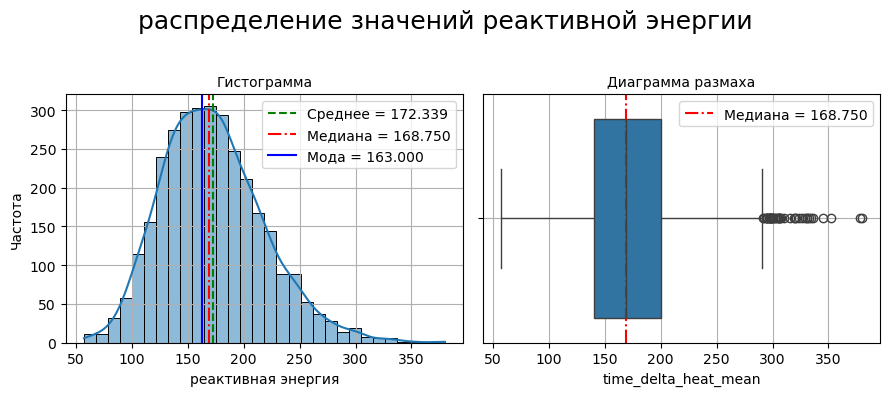

In [75]:
hist_and_box_with_stats(
    df_data_arc_grouped, 
    'time_delta_heat_mean',
    'распределение значений реактивной энергии', 
    'реактивная энергия',
    30
)

Распределение похоже на нормальное, смещено влево. Редкие выбросы в правой части.

In [76]:
df_data_arc_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   count_heat            3214 non-null   int64         
 1   начало_нагрева_дугой  3214 non-null   datetime64[ns]
 2   конец_нагрева_дугой   3214 non-null   datetime64[ns]
 3   активная_мощность     3214 non-null   float64       
 4   реактивная_мощность   3214 non-null   float64       
 5   time_delta_heat       3214 non-null   int32         
 6   common_power          3214 non-null   float64       
 7   coeff_power           3214 non-null   float64       
 8   total_energy          3214 non-null   float64       
 9   time_delta_heat_mean  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1)
memory usage: 263.6 KB


In [77]:
df_full_view(df_data_arc_grouped)

Размер таблицы: (3214, 10)

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   count_heat            3214 non-null   int64         
 1   начало_нагрева_дугой  3214 non-null   datetime64[ns]
 2   конец_нагрева_дугой   3214 non-null   datetime64[ns]
 3   активная_мощность     3214 non-null   float64       
 4   реактивная_мощность   3214 non-null   float64       
 5   time_delta_heat       3214 non-null   int32         
 6   common_power          3214 non-null   float64       
 7   coeff_power           3214 non-null   float64       
 8   total_energy          3214 non-null   float64       
 9   time_delta_heat_mean  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1)
memory usage: 263.6 KB
None

count_heat              0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_

count_heat начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
key                                                                           
1             5  2019-05-03 11:02:14 2019-05-03 11:28:37           0.607346   
2             4  2019-05-03 11:34:14 2019-05-03 11:53:18           0.534852   
3             5  2019-05-03 12:06:54 2019-05-03 12:32:19           0.812728   
4             4  2019-05-03 12:39:37 2019-05-03 12:57:50           0.676622   
5             4  2019-05-03 13:11:13 2019-05-03 13:33:55           0.563238   

     реактивная_мощность  time_delta_heat  common_power  coeff_power  \
key                                                                    
1               0.428564             1098      3.718736     0.706569   
2               0.363339              811      2.588349     0.684080   
3               0.587491              655      5.019223     0.725034   
4               0.514248              741      3.400038     0.765897   
5               0.421998              869      2.816980     0.758599   

     total_energy  time_delta_heat_mean  
key                                      
1      770.282114                219.60  
2      481.760005                202.75  
3      722.837668                131.00  
4      683.455597                185.25  
5      512.169934                217.25

Количество явных дубликатов: 0
Количество пропусков:
 count_heat              0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
time_delta_heat         0
common_power            0
coeff_power             0
total_energy            0
time_delta_heat_mean    0
dtype: int64


count_heat           начало_нагрева_дугой  \
count  3214.000000                           3214   
mean      4.628500  2019-07-05 19:17:48.712507904   
min       1.000000            2019-05-03 11:02:14   
25%       4.000000     2019-06-04 09:56:12.500000   
50%       4.000000     2019-07-03 05:45:05.500000   
75%       6.000000            2019-08-08 00:25:09   
max      16.000000            2019-09-06 16:49:05   
std       1.608647                            NaN   

                 конец_нагрева_дугой  активная_мощность  реактивная_мощность  \
count                           3214        3214.000000          3214.000000   
mean   2019-07-05 19:49:53.941506304           0.661331             0.485972   
min              2019-05-03 11:28:37           0.267676             0.196228   
25%    2019-06-04 10:36:34.750000128           0.573035             0.417415   
50%       2019-07-03 06:16:12.500000           0.652974             0.481639   
75%              2019-08-08 00:47:11           0.739388             0.543312   
max              2019-09-06 17:26:15           1.243889             0.960763   
std                              NaN           0.128372             0.097586   

       time_delta_heat  common_power  coeff_power  total_energy  \
count      3214.000000   3214.000000  3214.000000   3214.000000   
mean        794.579029      3.811050     0.734817    655.598650   
min          57.000000      0.331897     0.601191     33.430208   
25%         571.000000      2.776480     0.709514    444.626580   
50%         770.000000      3.694219     0.733513    620.101427   
75%         983.000000      4.696915     0.757610    827.671845   
max        4189.000000     15.288271     0.909516   4546.405812   
std         332.448622      1.502639     0.036497    308.944461   

       time_delta_heat_mean  
count           3214.000000  
mean             172.339290  
min               57.000000  
25%              140.000000  
50%              168.750000  
75%              200.383333  
max              380.000000  
std               45.606667

#### Итог анализа набора данных df_data_arc 

В наборе данных df_data_arc содержится 14876 записей. Исправлено одно отрицательное значение в признаке реактивной мощности.
Были добавленны следующие дополнительные признаки:
* общая мощность (**common_power**). Корень квадратный из суммы квадратов активной и реактивной мощности
* коэффициент мощности (**coeff_power**). Отношение реактивной к активной мощности
* затраченная энергия (**total_energy**). Произведение общей мощности на длительность воздействия.
* среднее значение интервалов нагрева (**time_delta_heat_mean**). Среднее от длительности работы нагрева в каждой партии.

Создан новый набор данных, с агрегацией данных по партиям (key). Получилась сводная информация о 3214 партиях плавки стали.

### Проанализируем  данные об объёме сыпучих материалов - data_bulk

Посмотрим краткий анализ полученных данных.

In [78]:
df_short_view(df_data_bulk)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
None

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7    

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [79]:
df_data_bulk.describe()

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          bulk_11      bulk_12     bulk_13      bulk_14      bulk_15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Из полученных данных видно, что в целом значения объемов сыпучих веществ лежат в положительном диапазоне.


Так как в услоовиии написано, что отсутсвие значений говорит о том, что сыпучие вещества в партию не добавлялись, то пропуски заполняем нулями.

In [80]:
df_data_bulk = df_data_bulk.fillna(0)
df_data_bulk.head()
df_data_bulk.describe()

key       bulk_1       bulk_2       bulk_3       bulk_4  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean   1624.383509     3.160435     1.779163    47.240332    33.830617   
std     933.337642    11.869164    21.217878    74.239954    56.034505   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     816.000000     0.000000     0.000000     0.000000     0.000000   
50%    1622.000000     0.000000     0.000000     0.000000     0.000000   
75%    2431.000000     0.000000     0.000000    80.000000    68.000000   
max    3241.000000   185.000000   325.000000   454.000000   281.000000   

            bulk_5       bulk_6       bulk_7       bulk_8       bulk_9  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean      2.633749    21.892298     2.441675     0.015660     0.463407   
std      20.918138    55.492582    31.944063     0.875978     6.154398   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     603.000000   503.000000   772.000000    49.000000   147.000000   

           bulk_10      bulk_11      bulk_12      bulk_13      bulk_14  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean      4.684564     4.345478   203.948226     1.041866   152.706616   
std      20.157323    22.699580   151.419639    14.114252    81.091421   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   105.000000     0.000000   104.000000   
50%       0.000000     0.000000   206.000000     0.000000   148.000000   
75%       0.000000     0.000000   263.000000     0.000000   202.000000   
max     159.000000   313.000000  1849.000000   305.000000   636.000000   

           bulk_15  
count  3129.000000  
mean    115.319271  
std      84.488698  
min       0.000000  
25%       0.000000  
50%     106.000000  
75%     204.000000  
max     405.000000

В признаке **bulk_8**  данные почти всегда отсутствуют. Только один раз фигурирует число 49.
Минимум везде - 0. Максимум лежит в преелах 49-1849. Т.е. различие в пределах одного порядка. 

In [81]:
calc_percent_of_zero(df_data_bulk)

В столбце key пустыми являются  0.0 % записей
В столбце bulk_1 пустыми являются  91.95 % записей
В столбце bulk_2 пустыми являются  99.3 % записей
В столбце bulk_3 пустыми являются  58.52 % записей
В столбце bulk_4 пустыми являются  67.59 % записей
В столбце bulk_5 пустыми являются  97.54 % записей
В столбце bulk_6 пустыми являются  81.59 % записей
В столбце bulk_7 пустыми являются  99.2 % записей
В столбце bulk_8 пустыми являются  99.97 % записей
В столбце bulk_9 пустыми являются  99.39 % записей
В столбце bulk_10 пустыми являются  94.38 % записей
В столбце bulk_11 пустыми являются  94.34 % записей
В столбце bulk_12 пустыми являются  21.7 % записей
В столбце bulk_13 пустыми являются  99.42 % записей
В столбце bulk_14 пустыми являются  10.32 % записей
В столбце bulk_15 пустыми являются  28.16 % записей


Предлагаю удалить все признаки где содержится менее 99% данных. Или, другими словами, где 0 содержатся более чем в 99 % строк.
Это такие признаки как :
* bulk_13 - пустыми являются  99.42 % записей
* bulk_9 - пустыми являются  99.39 % записей
* bulk_8 - пустыми являются  99.97 % записей
* bulk_7 - пустыми являются  99.2 % записей
* bulk_2 - пустыми являются  99.3 % записей



In [82]:
df_data_bulk_droped = df_data_bulk.drop(columns=[
#                                                    'bulk_1',
                                                    'bulk_2',
#                                                    'bulk_5',
                                                    'bulk_7',
                                                    'bulk_8',
                                                    'bulk_9',
#                                                    'bulk_10',
#                                                    'bulk_11',
                                                    'bulk_13',
])

In [83]:
df_data_bulk_droped.describe()

key       bulk_1       bulk_3       bulk_4       bulk_5  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean   1624.383509     3.160435    47.240332    33.830617     2.633749   
std     933.337642    11.869164    74.239954    56.034505    20.918138   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     816.000000     0.000000     0.000000     0.000000     0.000000   
50%    1622.000000     0.000000     0.000000     0.000000     0.000000   
75%    2431.000000     0.000000    80.000000    68.000000     0.000000   
max    3241.000000   185.000000   454.000000   281.000000   603.000000   

            bulk_6      bulk_10      bulk_11      bulk_12      bulk_14  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean     21.892298     4.684564     4.345478   203.948226   152.706616   
std      55.492582    20.157323    22.699580   151.419639    81.091421   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000   105.000000   104.000000   
50%       0.000000     0.000000     0.000000   206.000000   148.000000   
75%       0.000000     0.000000     0.000000   263.000000   202.000000   
max     503.000000   159.000000   313.000000  1849.000000   636.000000   

           bulk_15  
count  3129.000000  
mean    115.319271  
std      84.488698  
min       0.000000  
25%       0.000000  
50%     106.000000  
75%     204.000000  
max     405.000000

#### Создадим дополнительные признаки df_data_bulk

Добавим признак показывающий сколько раз добавляли добавки в расплав.

In [84]:
filtered_cols = [col for col in df_data_bulk_droped.columns if col.startswith('bulk_')]
df_data_bulk_droped['b_count'] = df_data_bulk_droped[filtered_cols].gt(0).sum(axis=1)

display(df_data_bulk_droped.sample(5))

key  bulk_1  bulk_3  bulk_4  bulk_5  bulk_6  bulk_10  bulk_11  bulk_12  \
12      13     0.0     0.0     0.0     0.0    72.0      0.0      0.0    410.0   
67      77     0.0   146.0     0.0     0.0   125.0      0.0      0.0    408.0   
2090  2162    46.0     0.0   186.0     0.0     0.0      0.0      0.0    416.0   
2019  2090     0.0     0.0    86.0     0.0     0.0      0.0      0.0      0.0   
2593  2692     0.0    66.0     0.0     0.0     0.0      0.0      0.0    308.0   

      bulk_14  bulk_15  b_count  
12      151.0    204.0        4  
67      215.0    203.0        5  
2090    246.0    227.0        5  
2019      0.0      0.0        1  
2593    100.0    106.0        4

#### Посмотрим графики df_data_bulk

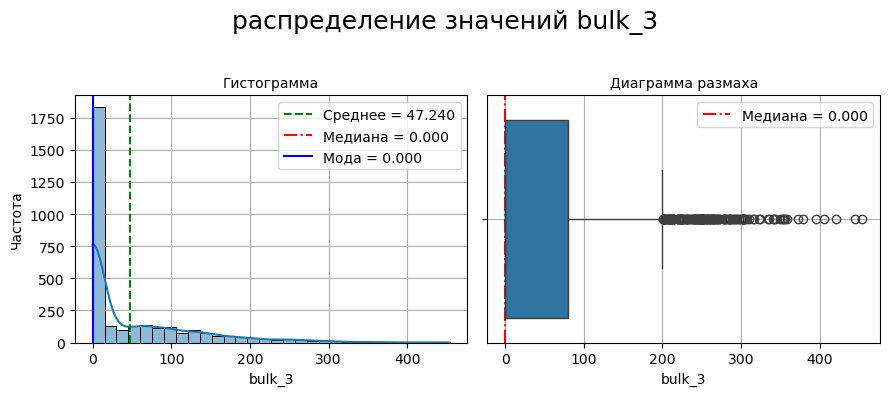

In [85]:
hist_and_box_with_stats(
    df_data_bulk_droped, 
    'bulk_3',
    'распределение значений bulk_3', 
    'bulk_3',
    30
)

Большое количество 0 значений перетягивают график на себя. Попробую построить график без 0.

Находим все колонки, начинающиеся с 'bulk_'

In [86]:
# Находим все колонки, начинающиеся с 'bulk_'
bulk_columns = [col for col in df_data_bulk_droped.columns if col.startswith('bulk_')]

Строим графики распределения по найденным столбцам

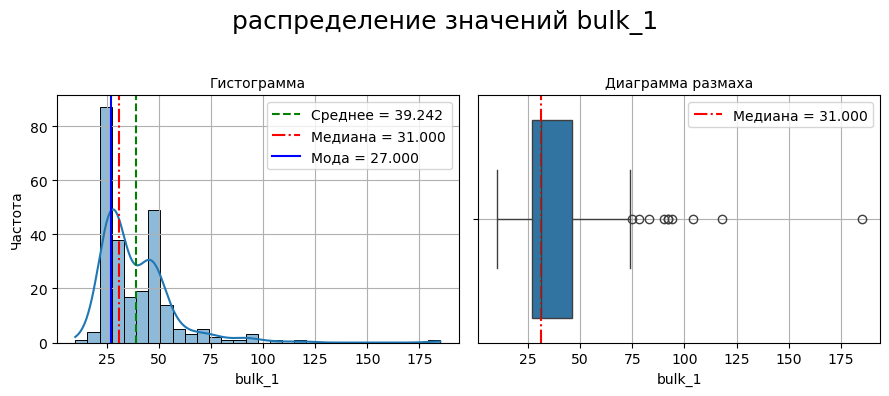

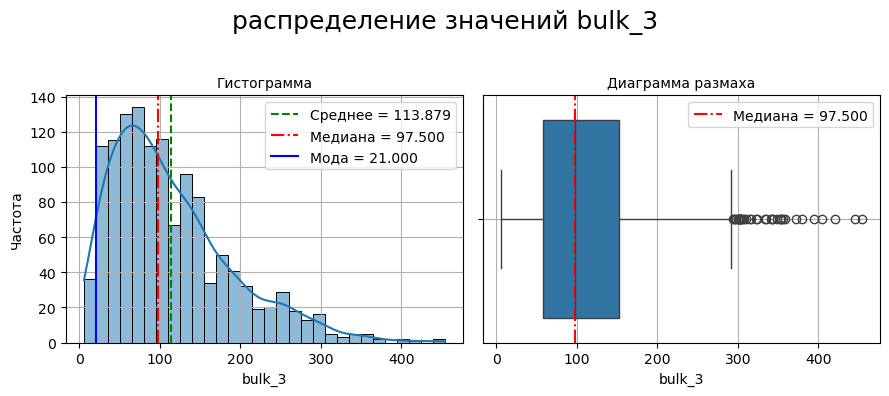

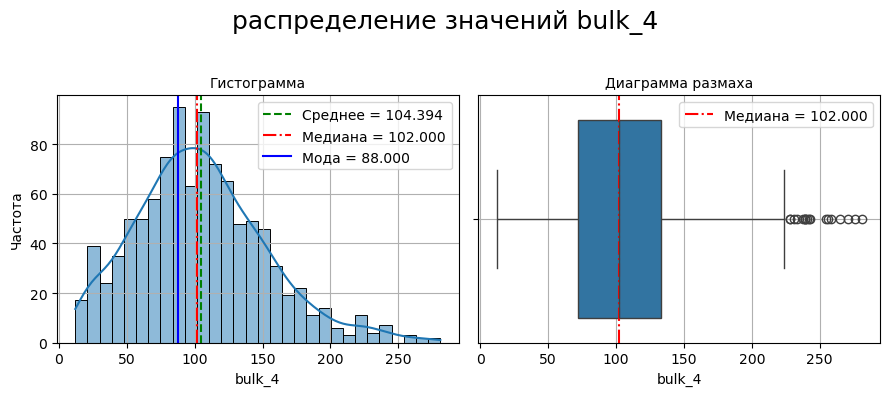

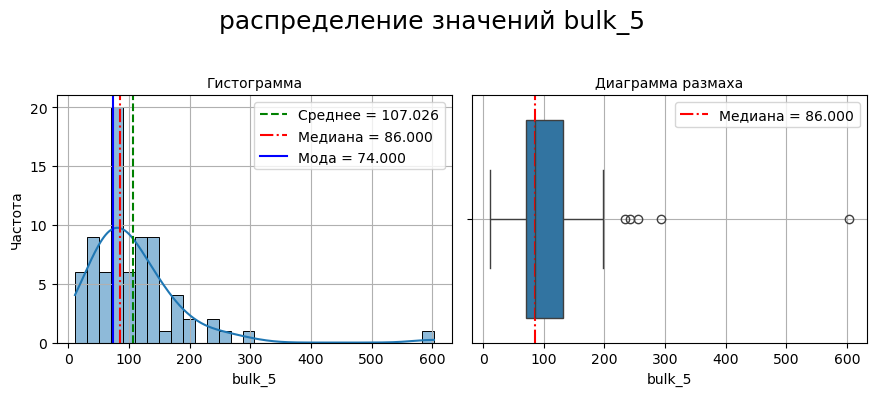

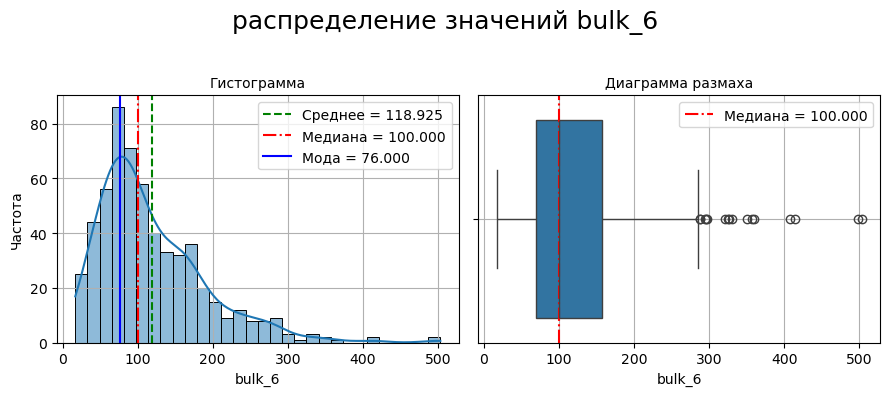

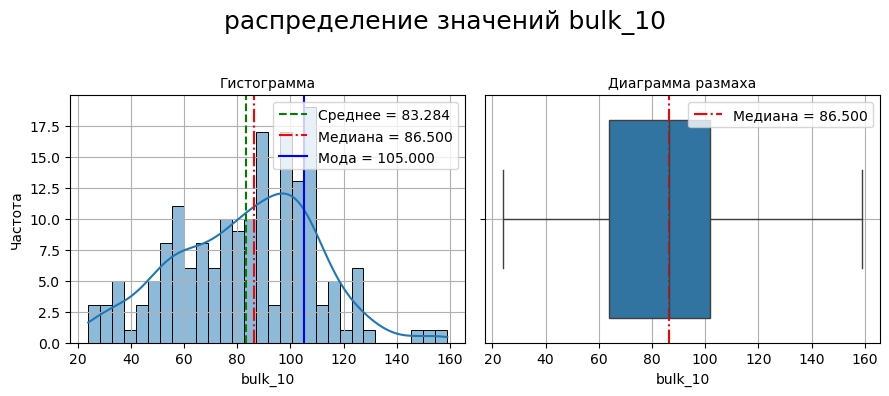

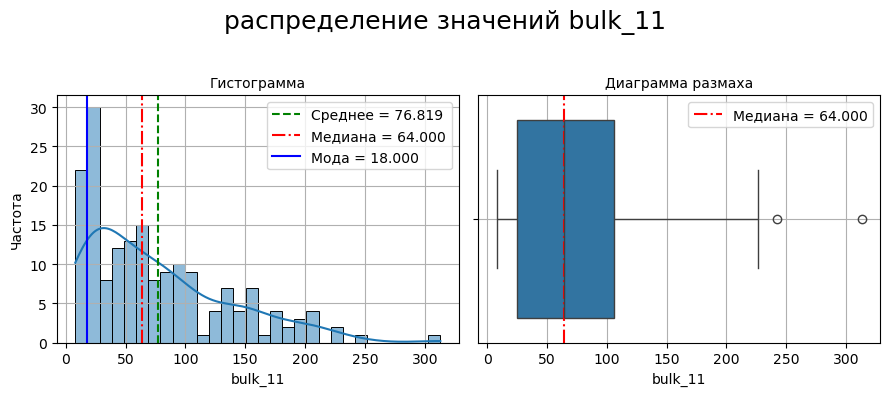

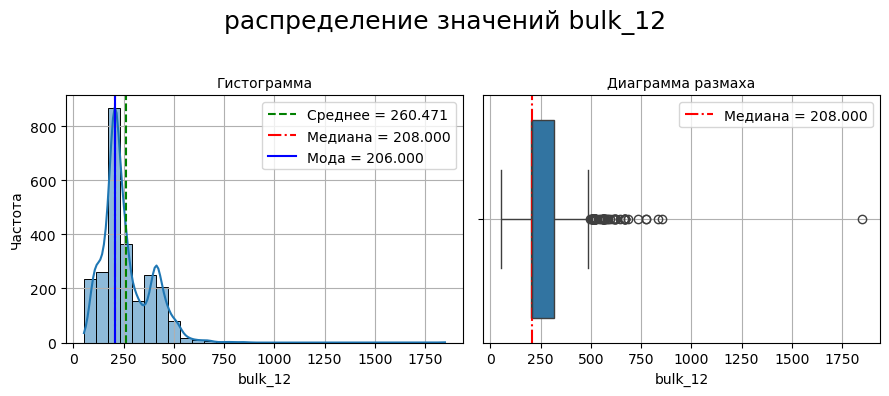

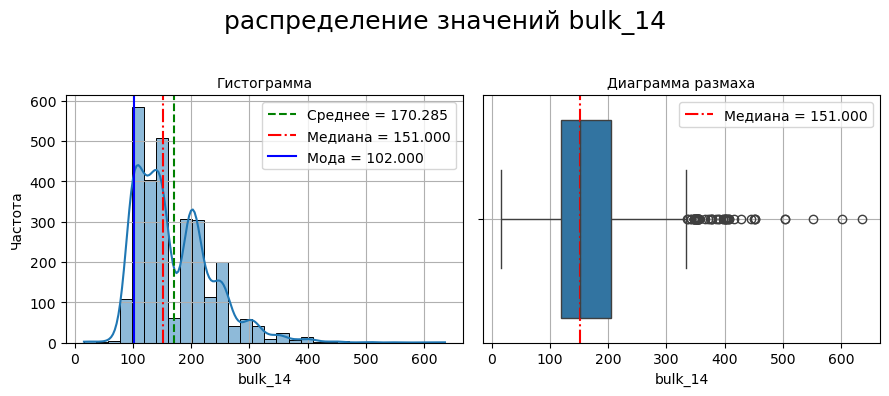

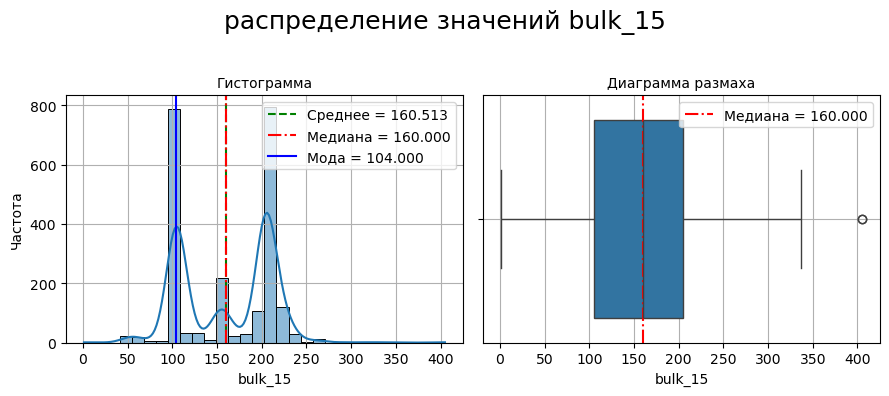

In [87]:
graph_batch (
    df_data_bulk_droped,#df,
#    df_data_bulk_time_diff_droped.loc[df_data_bulk_time_diff_droped['bulk_15_diff'] !=0],#df,
    bulk_columns, #column_list
    0 #exception
)

Так гораздо лучше видно что распределение смещено влево.


Выбросы есть практически в любом признаке. Но в bulk_12 есть одинокое аномальное значение которое уползло далеко вправо. Его значение на порядок отличается от медианы. Посмотрим на него внимательнее.

In [88]:
display(df_data_bulk_droped.loc[df_data_bulk_droped['bulk_12'] >1000])

key  bulk_1  bulk_3  bulk_4  bulk_5  bulk_6  bulk_10  bulk_11  bulk_12  \
303  322   185.0   101.0    58.0     0.0     0.0      0.0      0.0   1849.0   

     bulk_14  bulk_15  b_count  
303    636.0      0.0        5

Насколько оно аномально?

In [89]:
df_data_bulk_droped.sort_values(
    by='bulk_12', 
    ascending=False)\
    .head() 
        

key  bulk_1  bulk_3  bulk_4  bulk_5  bulk_6  bulk_10  bulk_11  bulk_12  \
303    322   185.0   101.0    58.0     0.0     0.0      0.0      0.0   1849.0   
1933  1999    54.0     0.0     0.0     0.0     0.0      0.0      0.0    853.0   
1755  1816    62.0     0.0    92.0     0.0     0.0      0.0      0.0    833.0   
308    327    67.0     0.0   119.0     0.0     0.0      0.0      0.0    775.0   
1410  1464    31.0     0.0   105.0     0.0     0.0      0.0      0.0    774.0   

      bulk_14  bulk_15  b_count  
303     636.0      0.0        5  
1933    366.0    290.0        4  
1755    249.0      0.0        4  
308     403.0    205.0        5  
1410    306.0    100.0        5

Похоже что первая цифра 1 лишняя. Уберём первую цифру.

In [90]:
df_data_bulk_droped.loc[df_data_bulk_droped['bulk_12'] >1000] = 1849 - 1000

Посмотрим количество уникальных значений в столбце key

In [91]:
print('Количество уникальных значений key:', len(df_data_bulk_droped['key'].unique()))

Количество уникальных значений key: 3128


3129 уникальных значений отличается от 3214 полученных в df_data_arc

#### Итог анализа набора данных df_data_bulk 

В наборе данных df_data_bulk содержится 3129 записей. 
Признак **key** содержит 3129 уникальных значений. Это отличается от 3214 полученных в df_data_arc
Все отсутствующие значения заменены на 0. Удалены следующие признаки имеющие менее 1% записей отличающихся от 0:
* bulk_13 - пустыми являются  99.42 % записей
* bulk_9 - пустыми являются  99.39 % записей
* bulk_8 - пустыми являются  99.97 % записей
* bulk_7 - пустыми являются  99.2 % записей
* bulk_2 - пустыми являются  99.3 % записей

Создан новый набор данных **df_data_bulk_droped** содержащий только необходимые признаки.

У признака **bulk_12** одно аномальное значение уменьшено до стандартного диапазона.

### Проанализируем данные о времени подачи сыпучих материалов- data_bulk_time

Посмотрим краткий анализ полученных данных.

In [92]:
df_short_view(df_data_bulk_time)

Размер таблицы: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_9 bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

Т.к. время указано для понимания последовательности шагов, значит надо заменить абсолютное время, на количество секунд прошедшее от начала процесса.
Для этого добавим столбец с временем начала и вычислим смещение. Склеивать будем c df_data_arc_grouped по номеру партии - признаку **key**.

In [93]:
df_data_arc_grouped['начало_нагрева_дугой']

key
1      2019-05-03 11:02:14
2      2019-05-03 11:34:14
3      2019-05-03 12:06:54
4      2019-05-03 12:39:37
5      2019-05-03 13:11:13
               ...        
3237   2019-09-06 11:31:25
3238   2019-09-06 12:16:25
3239   2019-09-06 14:17:00
3240   2019-09-06 15:25:31
3241   2019-09-06 16:49:05
Name: начало_нагрева_дугой, Length: 3214, dtype: datetime64[ns]

In [94]:
df_data_bulk_time_added = pd.merge(
    df_data_bulk_time,
    df_data_arc_grouped['начало_нагрева_дугой'], #
    left_on='key',          # столбец в левом датафрейме
    right_index=True,       # индекс в правом датафрейме
    how='left'              # тип JOIN
)

In [95]:
df_full_view(df_data_bulk_time_added)

Размер таблицы: (3129, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   3129 non-null   int64         
 1   bulk_1                252 non-null    datetime64[ns]
 2   bulk_2                22 non-null     datetime64[ns]
 3   bulk_3                1298 non-null   datetime64[ns]
 4   bulk_4                1014 non-null   datetime64[ns]
 5   bulk_5                77 non-null     datetime64[ns]
 6   bulk_6                576 non-null    datetime64[ns]
 7   bulk_7                25 non-null     datetime64[ns]
 8   bulk_8                1 non-null      datetime64[ns]
 9   bulk_9                19 non-null     datetime64[ns]
 10  bulk_10               176 non-null    datetime64[ns]
 11  bulk_11               177 non-null    datetime64[ns]
 12  bulk_12               2450 non-null   datetime64

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_9 bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15 начало_нагрева_дугой  
0 2019-05-03 11:10:43  2019-05-03 11:02:14  
1 2019-05-03 11:44:39  2019-05-03 11:34:14  
2 2019-05-03 12:16:16  2019-05-03 12:06:54  
3 2019-05-03 12:46:36  2019-05-03 12:39:37  
4 2019-05-03 13:30:47  2019-05-03 13:11:13

Количество явных дубликатов: 0
Количество пропусков:
 key                        0
bulk_1                  2877
bulk_2                  3107
bulk_3                  1831
bulk_4                  2115
bulk_5                  3052
bulk_6                  2553
bulk_7                  3104
bulk_8                  3128
bulk_9                  3110
bulk_10                 2953
bulk_11                 2952
bulk_12                  679
bulk_13                 3111
bulk_14                  323
bulk_15                  881
начало_нагрева_дугой       1
dtype: int64


key                         bulk_1  \
count  3129.000000                            252   
mean   1624.383509  2019-06-29 23:24:44.769841152   
min       1.000000            2019-05-03 17:42:46   
25%     816.000000     2019-05-29 14:48:48.500000   
50%    1622.000000            2019-06-25 11:09:13   
75%    2431.000000  2019-07-31 05:58:18.249999872   
max    3241.000000            2019-09-05 09:11:32   
std     933.337642                            NaN   

                              bulk_2                         bulk_3  \
count                             22                           1298   
mean   2019-07-12 07:57:13.045454592  2019-07-08 13:50:14.630970624   
min              2019-05-07 15:39:35            2019-05-03 20:40:25   
25%       2019-05-28 02:29:31.500000     2019-06-08 03:50:23.500000   
50%       2019-07-27 17:18:38.500000            2019-07-04 09:31:42   
75%              2019-08-13 02:20:08  2019-08-11 01:00:36.750000128   
max              2019-08-13 11:47:39            2019-09-06 12:26:52   
std                              NaN                            NaN   

                              bulk_4                         bulk_5  \
count                           1014                             77   
mean   2019-07-03 11:17:28.834319616  2019-07-13 17:18:29.090908928   
min              2019-05-03 11:28:48            2019-05-07 15:19:17   
25%    2019-05-30 21:36:11.249999872            2019-06-19 23:32:44   
50%       2019-06-28 03:44:42.500000            2019-07-25 17:59:41   
75%       2019-08-04 04:15:46.500000            2019-08-13 04:23:23   
max              2019-09-05 03:35:21            2019-09-02 18:16:52   
std                              NaN                            NaN   

                              bulk_6                         bulk_7  \
count                            576                             25   
mean   2019-07-06 13:50:06.345486080  2019-07-27 18:09:05.079999744   
min              2019-05-03 19:09:15            2019-05-07 18:11:01   
25%       2019-06-06 22:46:10.500000            2019-07-20 23:48:47   
50%       2019-07-09 03:34:57.500000            2019-07-27 18:07:02   
75%    2019-08-07 18:55:01.249999872            2019-08-13 04:19:43   
max              2019-09-06 16:24:28            2019-09-05 19:07:49   
std                              NaN                            NaN   

                    bulk_8                         bulk_9  \
count                    1                             19   
mean   2019-07-08 17:14:53  2019-06-23 08:08:47.578947328   
min    2019-07-08 17:14:53            2019-05-14 11:57:58   
25%    2019-07-08 17:14:53            2019-05-14 14:31:08   
50%    2019-07-08 17:14:53            2019-05-14 16:55:09   
75%    2019-07-08 17:14:53            2019-08-16 05:43:31   
max    2019-07-08 17:14:53            2019-08-16 09:11:56   
std                    NaN                            NaN   

                             bulk_10                        bulk_11  \
count                            176                            177   
mean   2019-07-06 23:55:10.954545408  2019-07-15 07:01:00.615819264   
min              2019-05-06 07:54:02            2019-05-05 23:43:24   
25%       2019-06-02 05:12:00.500000            2019-06-14 20:24:48   
50%              2019-07-06 07:05:20            2019-07-24 11:17:22   
75%    2019-08-04 02:23:35.750000128            2019-08-11 05:21:01   
max              2019-09-04 10:03:22            2019-09-06 05:03:14   
std                              NaN                            NaN   

                             bulk_12                        bulk_13  \
count                           2450                             18   
mean   2019-07-05 22:55:11.468571392  2019-07-01 18:32:46.944444416   
min              2019-05-03 11:24:31            2019-05-05 02:10:21   
25%    2019-06-03 12:48:47.249999872  2019-05-29 10:43:31.249999872   
50%              2019-07-03 01:32:00     2019-07-01 12:59:36.500000   
7

In [96]:
# Находим все колонки, начинающиеся с 'bulk_'
bulk_columns = [col for col in df_data_bulk_time_added.columns if col.startswith('bulk_')]
# добавим столбцы с разницей в секундах.
df_data_bulk_time_added = delta_calculation(df_data_bulk_time_added, bulk_columns, 'начало_нагрева_дугой')


Создан столбец bulk_1_diff
Создан столбец bulk_2_diff
Создан столбец bulk_3_diff
Создан столбец bulk_4_diff
Создан столбец bulk_5_diff
Создан столбец bulk_6_diff
Создан столбец bulk_7_diff
Создан столбец bulk_8_diff
Создан столбец bulk_9_diff
Создан столбец bulk_10_diff
Создан столбец bulk_11_diff
Создан столбец bulk_12_diff
Создан столбец bulk_13_diff
Создан столбец bulk_14_diff
Создан столбец bulk_15_diff


In [97]:
# удалим ненужные исходные признаки.
df_data_bulk_time_diff = df_data_bulk_time_added.drop(columns =  bulk_columns)

In [98]:
df_full_view(df_data_bulk_time_diff)

Размер таблицы: (3129, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   3129 non-null   int64         
 1   начало_нагрева_дугой  3128 non-null   datetime64[ns]
 2   bulk_1_diff           3129 non-null   float64       
 3   bulk_2_diff           3129 non-null   float64       
 4   bulk_3_diff           3129 non-null   float64       
 5   bulk_4_diff           3129 non-null   float64       
 6   bulk_5_diff           3129 non-null   float64       
 7   bulk_6_diff           3129 non-null   float64       
 8   bulk_7_diff           3129 non-null   float64       
 9   bulk_8_diff           3129 non-null   float64       
 10  bulk_9_diff           3129 non-null   float64       
 11  bulk_10_diff          3129 non-null   float64       
 12  bulk_11_diff          3129 non-null   float64   

key начало_нагрева_дугой  bulk_1_diff  bulk_2_diff  bulk_3_diff  \
0    1  2019-05-03 11:02:14          0.0          0.0          0.0   
1    2  2019-05-03 11:34:14          0.0          0.0          0.0   
2    3  2019-05-03 12:06:54          0.0          0.0          0.0   
3    4  2019-05-03 12:39:37          0.0          0.0          0.0   
4    5  2019-05-03 13:11:13          0.0          0.0          0.0   

   bulk_4_diff  bulk_5_diff  bulk_6_diff  bulk_7_diff  bulk_8_diff  \
0       1594.0          0.0          0.0          0.0          0.0   
1        156.0          0.0          0.0          0.0          0.0   
2       1545.0          0.0          0.0          0.0          0.0   
3        225.0          0.0          0.0          0.0          0.0   
4       1174.0          0.0          0.0          0.0          0.0   

   bulk_9_diff  bulk_10_diff  bulk_11_diff  bulk_12_diff  bulk_13_diff  \
0          0.0           0.0           0.0        1337.0           0.0   
1          0.0           0.0           0.0        1156.0           0.0   
2          0.0           0.0           0.0        1219.0           0.0   
3          0.0           0.0           0.0        1103.0           0.0   
4          0.0           0.0           0.0        1174.0           0.0   

   bulk_14_diff  bulk_15_diff  
0         756.0         509.0  
1         863.0         625.0  
2         847.0         562.0  
3         694.0         419.0  
4        1379.0        1174.0

Количество явных дубликатов: 0
Количество пропусков:
 key                     0
начало_нагрева_дугой    1
bulk_1_diff             0
bulk_2_diff             0
bulk_3_diff             0
bulk_4_diff             0
bulk_5_diff             0
bulk_6_diff             0
bulk_7_diff             0
bulk_8_diff             0
bulk_9_diff             0
bulk_10_diff            0
bulk_11_diff            0
bulk_12_diff            0
bulk_13_diff            0
bulk_14_diff            0
bulk_15_diff            0
dtype: int64


key           начало_нагрева_дугой   bulk_1_diff   bulk_2_diff  \
count  3129.000000                           3128   3129.000000   3129.000000   
mean   1624.383509  2019-07-05 20:38:55.953324800    158.141898     34.729946   
min       1.000000            2019-05-03 11:02:14      0.000000      0.000000   
25%     816.000000            2019-06-04 09:27:45      0.000000      0.000000   
50%    1622.000000            2019-07-03 05:19:37      0.000000      0.000000   
75%    2431.000000            2019-08-08 00:02:33      0.000000      0.000000   
max    3241.000000            2019-09-06 16:49:05  21182.000000  20612.000000   
std     933.337642                            NaN    776.464356    548.039651   

        bulk_3_diff   bulk_4_diff   bulk_5_diff   bulk_6_diff   bulk_7_diff  \
count   3129.000000   3129.000000   3129.000000   3129.000000   3129.000000   
mean     679.742729    539.021732     61.414509    348.031320     23.901886   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%     1220.000000    720.000000      0.000000      0.000000      0.000000   
max    19317.000000  17530.000000  17281.000000  23500.000000  16702.000000   
std     1196.687850   1095.069762    546.897712   1082.467899    396.212837   

       bulk_8_diff  bulk_9_diff  bulk_10_diff  bulk_11_diff  bulk_12_diff  \
count  3129.000000  3129.000000   3129.000000   3129.000000   3129.000000   
mean      0.387344     9.523810     91.024609     94.093960   1327.620965   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000    177.000000   
50%       0.000000     0.000000      0.000000      0.000000   1337.000000   
75%       0.000000     0.000000      0.000000      0.000000   1904.000000   
max    1212.000000  3064.000000   7678.000000  11957.000000  23107.000000   
std      21.667053   138.033347    462.526366    507.436414   1279.021010   

       bulk_13_diff  bulk_14_diff  bulk_15_diff  
count   3129.000000   3129.000000   3129.000000  
mean      25.387983   1298.562160    773.501438  
min        0.000000      0.000000      0.000000  
25%        0.000000    847.000000      0.000000  
50%        0.000000   1199.000000    687.000000  
75%        0.000000   1642.000000   1073.000000  
max    22400.000000  22045.000000  21753.000000  
std      548.851768   1026.797447    925.155291

In [99]:
calc_percent_of_zero(df_data_bulk_time_diff)

В столбце key пустыми являются  0.0 % записей
В столбце начало_нагрева_дугой пустыми являются  0.0 % записей
В столбце bulk_1_diff пустыми являются  91.95 % записей
В столбце bulk_2_diff пустыми являются  99.3 % записей
В столбце bulk_3_diff пустыми являются  58.52 % записей
В столбце bulk_4_diff пустыми являются  67.59 % записей
В столбце bulk_5_diff пустыми являются  97.54 % записей
В столбце bulk_6_diff пустыми являются  81.62 % записей
В столбце bulk_7_diff пустыми являются  99.2 % записей
В столбце bulk_8_diff пустыми являются  99.97 % записей
В столбце bulk_9_diff пустыми являются  99.39 % записей
В столбце bulk_10_diff пустыми являются  94.38 % записей
В столбце bulk_11_diff пустыми являются  94.34 % записей
В столбце bulk_12_diff пустыми являются  21.7 % записей
В столбце bulk_13_diff пустыми являются  99.42 % записей
В столбце bulk_14_diff пустыми являются  10.32 % записей
В столбце bulk_15_diff пустыми являются  28.16 % записей


Предлагаю удалить все признаки где содержится менее 99% данных. Или, другими словами, где 0 содержатся более чем в 99 % строк.
Это такие признаки как :
* bulk_2_diff пустыми являются  99.3 % записей
* bulk_7_diff пустыми являются  99.2 % записей
* bulk_8_diff пустыми являются  99.97 % записей
* bulk_9_diff пустыми являются  99.39 % записей
* bulk_13_diff пустыми являются  99.42 % записей

In [100]:
df_data_bulk_time_diff_droped = df_data_bulk_time_diff.drop(columns=[
                                        'bulk_2_diff',
                                        'bulk_7_diff',
                                        'bulk_8_diff',
                                        'bulk_9_diff',
                                        'bulk_13_diff',
])

In [101]:
df_short_view(df_data_bulk_time_diff_droped)

Размер таблицы: (3129, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   3129 non-null   int64         
 1   начало_нагрева_дугой  3128 non-null   datetime64[ns]
 2   bulk_1_diff           3129 non-null   float64       
 3   bulk_3_diff           3129 non-null   float64       
 4   bulk_4_diff           3129 non-null   float64       
 5   bulk_5_diff           3129 non-null   float64       
 6   bulk_6_diff           3129 non-null   float64       
 7   bulk_10_diff          3129 non-null   float64       
 8   bulk_11_diff          3129 non-null   float64       
 9   bulk_12_diff          3129 non-null   float64       
 10  bulk_14_diff          3129 non-null   float64       
 11  bulk_15_diff          3129 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memo

key начало_нагрева_дугой  bulk_1_diff  bulk_3_diff  bulk_4_diff  \
0    1  2019-05-03 11:02:14          0.0          0.0       1594.0   
1    2  2019-05-03 11:34:14          0.0          0.0        156.0   
2    3  2019-05-03 12:06:54          0.0          0.0       1545.0   
3    4  2019-05-03 12:39:37          0.0          0.0        225.0   
4    5  2019-05-03 13:11:13          0.0          0.0       1174.0   

   bulk_5_diff  bulk_6_diff  bulk_10_diff  bulk_11_diff  bulk_12_diff  \
0          0.0          0.0           0.0           0.0        1337.0   
1          0.0          0.0           0.0           0.0        1156.0   
2          0.0          0.0           0.0           0.0        1219.0   
3          0.0          0.0           0.0           0.0        1103.0   
4          0.0          0.0           0.0           0.0        1174.0   

   bulk_14_diff  bulk_15_diff  
0         756.0         509.0  
1         863.0         625.0  
2         847.0         562.0  
3         694.0         419.0  
4        1379.0        1174.0

##### Посмотрим графики

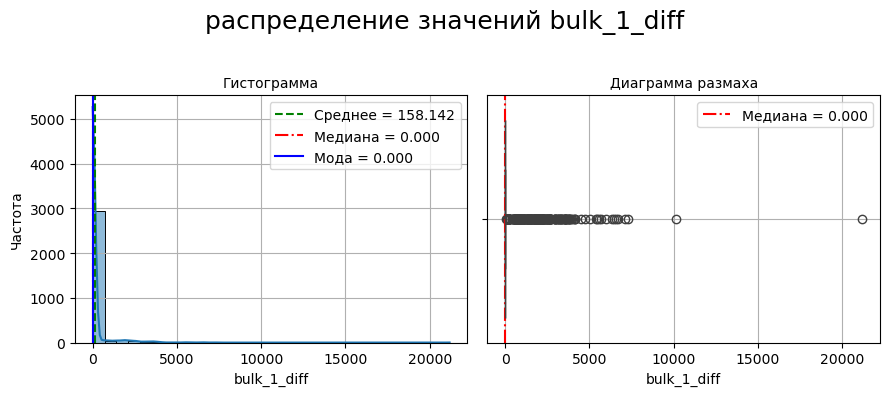

In [102]:
hist_and_box_with_stats(
    df_data_bulk_time_diff_droped, 
    'bulk_1_diff',
    'распределение значений bulk_1_diff', 
    'bulk_1_diff',
    30
)

Опять весь график деформирован из-за большого количества 0. Исправим это.

In [103]:
# Находим все колонки, начинающиеся с 'bulk_'
bulk_columns = [col for col in df_data_bulk_time_diff_droped.columns if col.startswith('bulk_')]

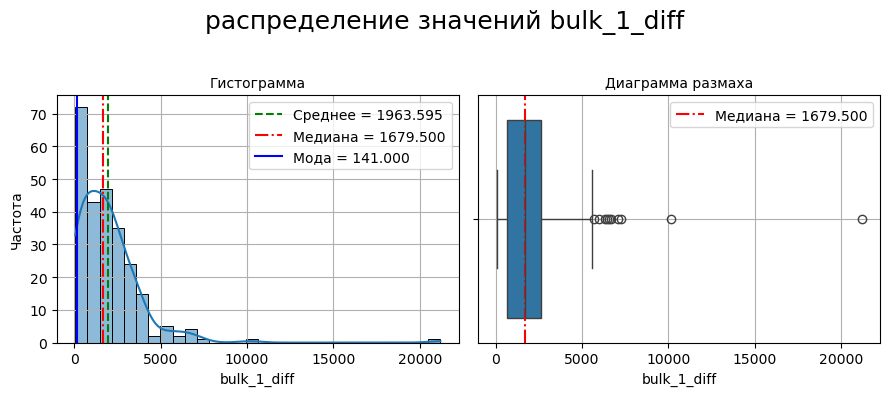

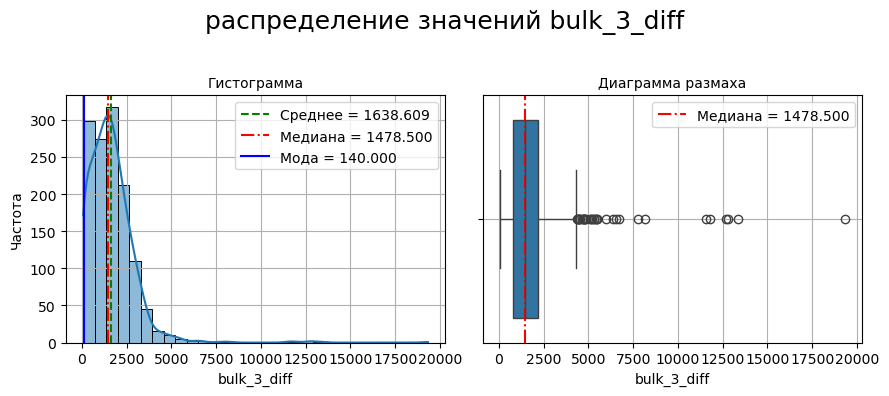

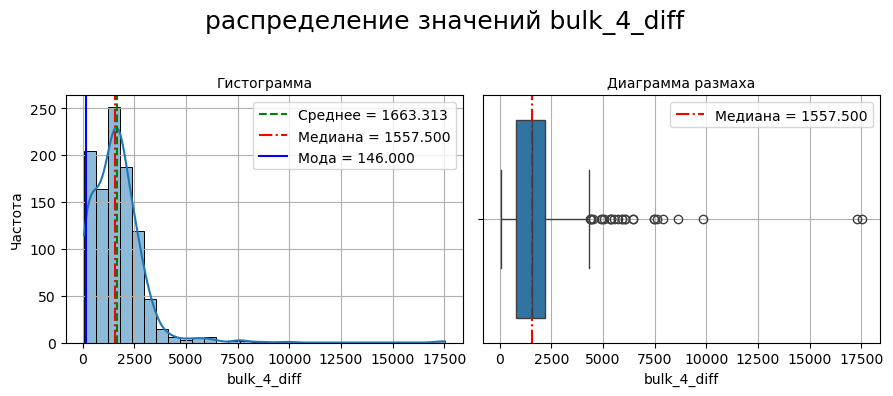

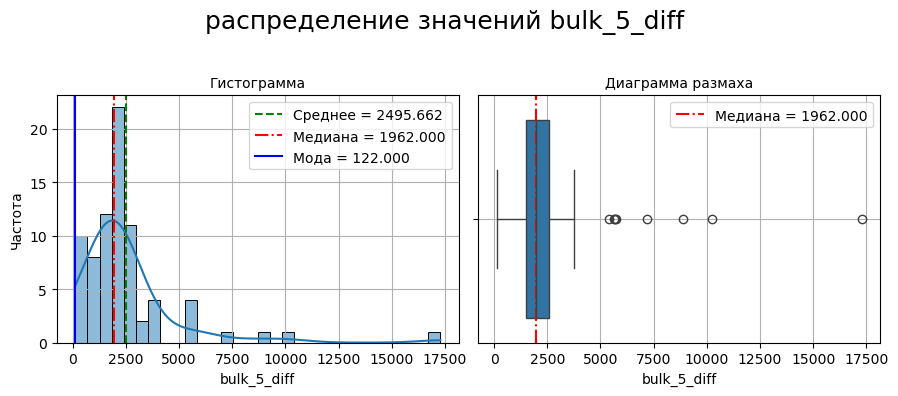

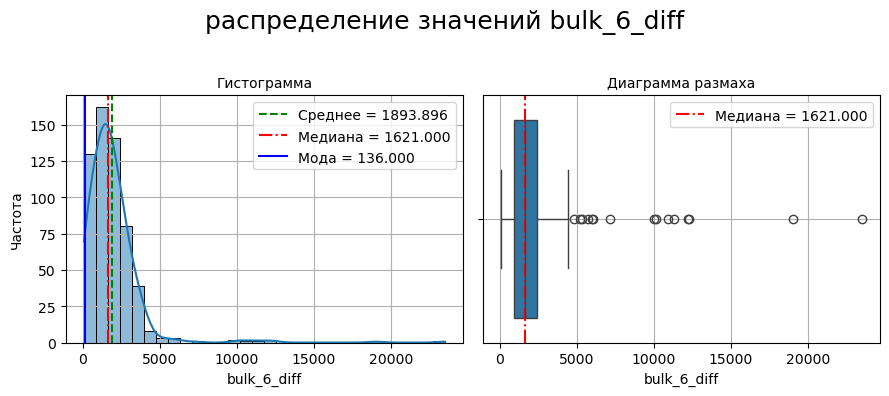

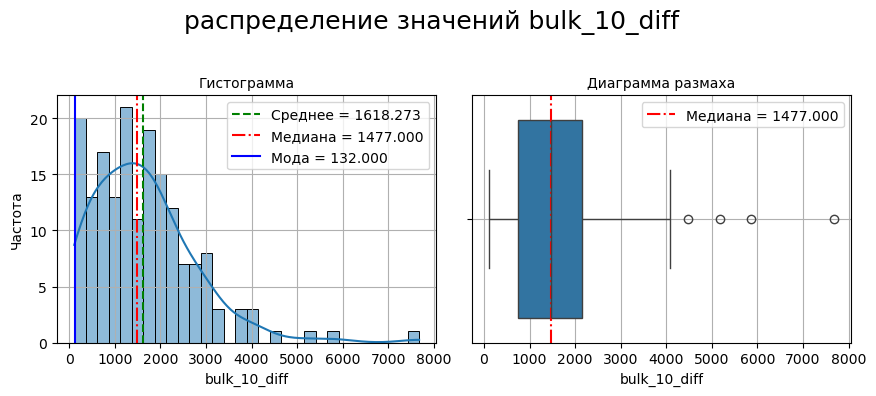

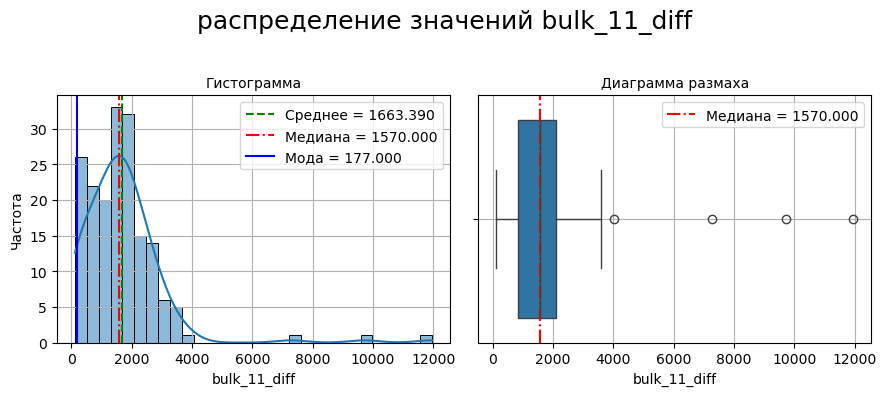

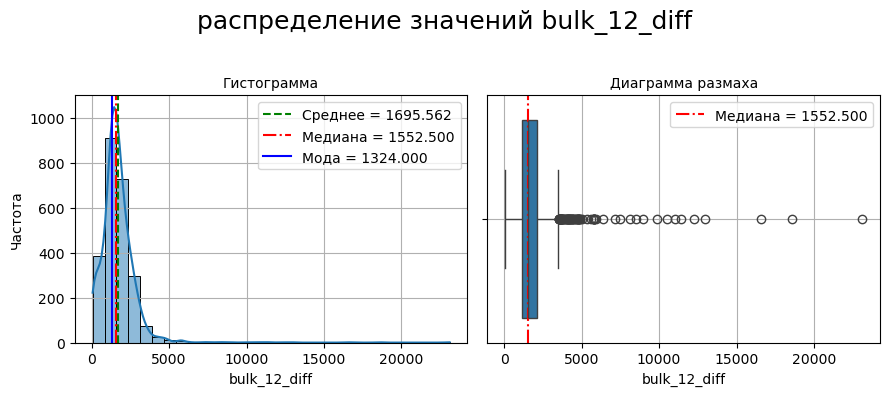

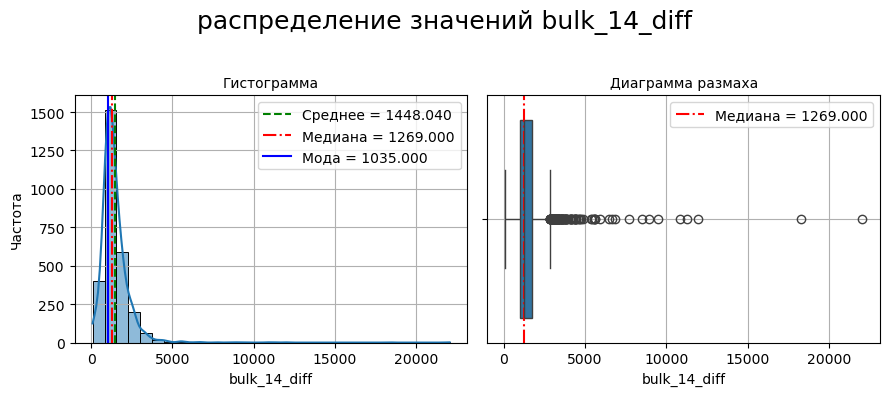

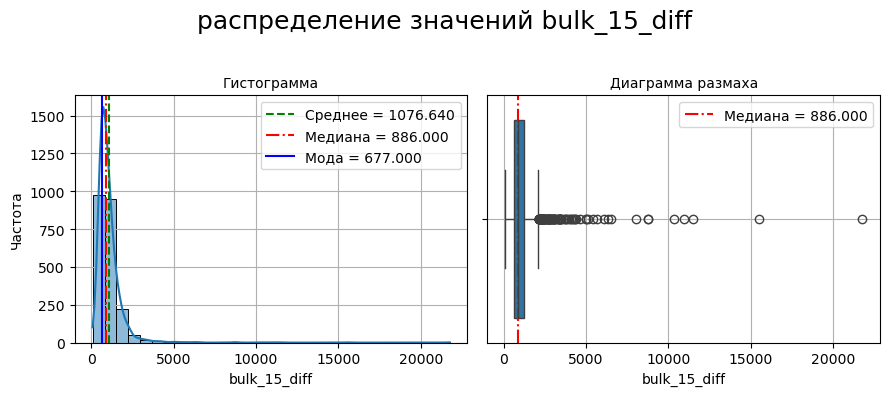

In [104]:
graph_batch (
    df_data_bulk_time_diff_droped,#df,
    bulk_columns, #column_list
    0 #exception
)

Есть аномальное значение с разницей в > 20к секунд. Посмотрим на него и его ближайших соседей.

In [105]:
display(df_data_bulk_time_diff_droped.loc[df_data_bulk_time_diff_droped['bulk_1_diff'] > 7000])

key начало_нагрева_дугой  bulk_1_diff  bulk_3_diff  bulk_4_diff  \
105    118  2019-05-07 22:57:35      10163.0          0.0       9858.0   
2036  2108  2019-07-27 10:41:13      21182.0          0.0      17530.0   
2475  2567  2019-08-13 05:30:55       7104.0          0.0          0.0   
3072  3181  2019-09-04 13:59:48       7280.0       3039.0          0.0   

      bulk_5_diff  bulk_6_diff  bulk_10_diff  bulk_11_diff  bulk_12_diff  \
105        8856.0          0.0           0.0           0.0           0.0   
2036      17281.0          0.0           0.0           0.0           0.0   
2475          0.0          0.0           0.0           0.0           0.0   
3072          0.0          0.0           0.0           0.0        2400.0   

      bulk_14_diff  bulk_15_diff  
105            0.0           0.0  
2036           0.0           0.0  
2475           0.0           0.0  
3072        1653.0        1234.0

Судя по всему вся партия имеет значения временной разницы больше чем в остальных партиях. </br>
Является ли это аномалией ? Да. </br>
Является ли это ошибкой ? Не известно.

In [106]:
df_data_bulk_time_diff_droped.sort_values(
    by='bulk_15_diff', 
    ascending=False)\
    .head() 

key начало_нагрева_дугой  bulk_1_diff  bulk_3_diff  bulk_4_diff  \
1629  1689  2019-07-05 08:07:21          0.0          0.0          0.0   
611    641  2019-05-28 03:43:47          0.0          0.0      17291.0   
767    801  2019-06-03 14:47:17          0.0      12821.0          0.0   
608    638  2019-05-27 17:46:52          0.0      13343.0          0.0   
43      46  2019-05-05 03:52:56          0.0          0.0          0.0   

      bulk_5_diff  bulk_6_diff  bulk_10_diff  bulk_11_diff  bulk_12_diff  \
1629          0.0      23500.0           0.0           0.0       23107.0   
611           0.0          0.0           0.0           0.0       16579.0   
767           0.0          0.0           0.0           0.0       12249.0   
608           0.0          0.0           0.0           0.0       12940.0   
43            0.0      12229.0           0.0           0.0       11422.0   

      bulk_14_diff  bulk_15_diff  
1629       22045.0       21753.0  
611            0.0       15498.0  
767        11952.0       11482.0  
608        11243.0       10945.0  
43         10833.0       10354.0

Такой же рост значений справа на лево. Значения высокие, но ошибкой это скорее всего не является.

In [107]:
print('Kоличество уникальных значений:', len(df_data_bulk_time_diff_droped['key'].unique()))

Kоличество уникальных значений: 3129


#### Итог анализа набора данных df_data_bulk_time

В наборе данных df_data_bulk_time содержится 3129 записей. Признак key содержит 3129 уникальных значений. Это отличается от 3214 полученных в df_data_arc. Все отсутствующие значения заменены на 0. Удалены следующие признаки имеющие менее 1% записей отличающихся от 0:
* bulk_2_diff пустыми являются 99.3 % записей
* bulk_7_diff пустыми являются 99.2 % записей
* bulk_8_diff пустыми являются 99.97 % записей
* bulk_9_diff пустыми являются 99.39 % записей
* bulk_13_diff пустыми являются 99.42 % записей


Создан новый набор данных без указанных столбцов : df_data_bulk_time_diff_droped

### Проанализируем данные о продувке сплава газом - data_gas

Посмотрим краткий анализ полученных данных.

In [108]:
df_short_view(df_data_gas)

Размер таблицы: (3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

key      0
газ_1    0
dtype: int64


key      газ_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [109]:
df_data_gas.isnull().sum()

key      0
газ_1    0
dtype: int64

Пропусков значений нет.

In [110]:
df_data_gas.describe()

key        газ_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

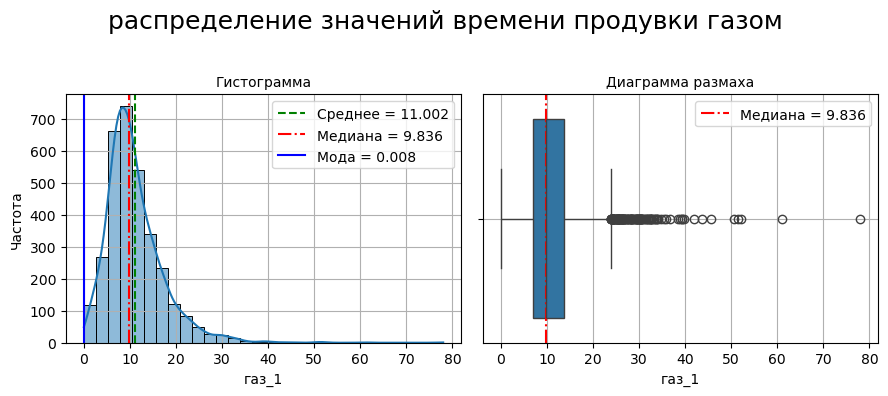

In [111]:
hist_and_box_with_stats(
    df_data_gas, 
    'газ_1',
    'распределение значений времени продувки газом', 
    'газ_1',
    30
)

Все значения >0 . Распределение похоже на нормальное, смещено влево.

Есть знаения которые выделяются на общем фоне, но разница между ними и медианой не превышает одного порядка.

In [112]:
print('Kоличество уникальных значений:', len(df_data_gas['key'].unique()))

Kоличество уникальных значений: 3239


#### Итог анализа набора данных df_data_gas

В наборе данных df_data_gas содержится 3239 записей. Признак key содержит 3239 уникальных значений. Это отличается от 3214 полученных в df_data_arc.
Пропусков значений нет. Все значения положительные.

### Проанализируем данные об измерениях температуры - data_temp

#### Проверим на пропуски

In [113]:
df_data_temp.isnull().sum()

key                0
время_замера       0
температура     3427
dtype: int64

В столбце **температура** зафиксированны пропуски значений. Эти записи надо удалить, т.к. они не несут нужной нам информации.

In [114]:
display(df_data_temp.loc[df_data_temp['температура'].isnull()].sample(5))

key        время_замера  температура
15352  2745 2019-08-19 18:49:53          NaN
14519  2597 2019-08-14 09:11:35          NaN
16183  2897 2019-08-25 08:28:40          NaN
15018  2685 2019-08-17 10:30:05          NaN
17769  3180 2019-09-04 13:40:28          NaN

Ничего осмысленного с этими данными мы сделать не можем, поэтому просто удалим эти записи.

In [115]:
df_data_temp_cleared = df_data_temp.dropna()

Посмотрим краткий анализ полученных данных.

In [116]:
df_short_view(df_data_temp_cleared)

Размер таблицы: (14665, 3)

<class 'pandas.core.frame.DataFrame'>
Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   время_замера  14665 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB
None

key             0
время_замера    0
температура     0
dtype: int64


key        время_замера  температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

In [209]:
df_data_temp_cleared['температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

Температура плавления стали варьируется от 1370°C до 1530°C в зависимости от её состава, типа и количества легирующих элементов, таких как углерод. Различные марки стали, например, углеродистая или нержавеющая, будут плавиться при разных температурах внутри этого диапазона.

Есть температурные пробы ниже температуры плавления и значительно выше. Нужно уточнить у технологов что это значит. Возможно это нормальные значения в рамках текущих процессов. Пока удалять эти аномалии не будем.

In [118]:
result = df_data_temp_cleared['key'].value_counts().value_counts().sort_index()
result_df = pd.DataFrame({'copies': result.index, 'count': result.values})
print(result_df)

    copies  count
0        1    741
1        2     32
2        3    136
3        4    395
4        5    688
5        6    580
6        7    388
7        8    152
8        9     66
9       10     21
10      11      7
11      12      3
12      13      2
13      14      2
14      16      2
15      17      1


In [119]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   copies  16 non-null     int64
 1   count   16 non-null     int64
dtypes: int64(2)
memory usage: 388.0 bytes


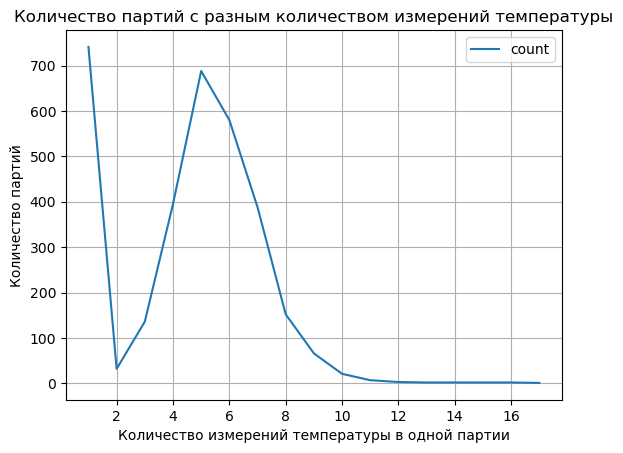

In [120]:
result_df.plot(x='copies', y='count')
plt.title('Количество партий с разным количеством измерений температуры')
plt.xlabel('Количество измерений температуры в одной партии')                   # Подпишем ось X
plt.ylabel('Количество партий')                 # Подпишем ось Y
plt.grid(True)                      # Включим сетку
plt.show()                          # Отобразим график

Получается что некоторые ключи повторяются от 1 до 17 раз. Т.е. в некоторых партиях барали пробу температуры от 1 до 17 раз.

##### Добавим дополнительные признаки

Т.к. нас интересует итоговый набор данных где каждая запись соответствует одной партии, попробуем сгруппировать данные и получить следующие признаки:
* номер партии
* количество измерений температуры
* время первого измерения
* время последнего измерения температуры
* температура первого измерения
* температура последнего измерения температуры
* разница между последним и первым измерением в секундах
* разница в температуре между первым и последним измерением.

Для начала подсчитаем количество температурных проб в каждой партии.

In [121]:
result_key = pd.DataFrame({
    'key': df_data_temp_cleared['key'].value_counts().index,
    'count_probes': df_data_temp_cleared['key'].value_counts().values
})
result_key = result_key.sort_values(by='key')
display(result_key)
#result_key.info()

key  count_probes
644      1             6
1911     2             5
1201     3             6
1910     4             5
1909     5             5
...    ...           ...
3011  3237             1
3010  3238             1
3009  3239             1
3008  3240             1
3007  3241             1

[3216 rows x 2 columns]

У нас есть партии с одной температурной пробой. Это аномалии. Т.к. по одной температурной пробе нельзя определить или первую или последнюю температуру, значит партии с одним измерением температуры нужно удалить.

In [122]:
result_key = result_key.loc[result_key['count_probes'] > 1]
result_key.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 644 to 1224
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   key           2475 non-null   int64
 1   count_probes  2475 non-null   int64
dtypes: int64(2)
memory usage: 58.0 KB


In [123]:
# Находим индексы строк с минимальным временем для каждого key
min_time_indices = df_data_temp.groupby('key')['время_замера'].idxmin()

# Извлекаем нужные строки по найденным индексам
result_key_min = df_data_temp.loc[min_time_indices, ['key', 'время_замера', 'температура']]#.reset_index(drop=True)

result_key_min = result_key_min.set_index('key')
result_key_min.columns = ['time_temp_first_probe', 'temp_first_probe']

result_key_min.info()
result_key_min.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time_temp_first_probe  3216 non-null   datetime64[ns]
 1   temp_first_probe       3216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.4 KB


time_temp_first_probe  temp_first_probe
key                                        
1     2019-05-03 11:02:04            1571.0
2     2019-05-03 11:34:04            1581.0
3     2019-05-03 12:06:44            1596.0
4     2019-05-03 12:39:27            1601.0
5     2019-05-03 13:11:03            1576.0

In [124]:
# Находим индексы строк с минимальным временем для каждого key
max_time_indices = df_data_temp.groupby('key')['время_замера'].idxmax()

# Извлекаем нужные строки по найденным индексам
result_key_max = df_data_temp.loc[max_time_indices, ['key', 'время_замера', 'температура']]#.reset_index(drop=True)


result_key_max = result_key_max.set_index('key')
result_key_max.columns = ['time_temp_last_probe', 'temp_last_probe']

result_key_max.info()
result_key_max.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time_temp_last_probe  3216 non-null   datetime64[ns]
 1   temp_last_probe       2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.4 KB


time_temp_last_probe  temp_last_probe
key                                      
1    2019-05-03 11:30:38           1613.0
2    2019-05-03 11:55:09           1602.0
3    2019-05-03 12:35:57           1599.0
4    2019-05-03 12:59:47           1625.0
5    2019-05-03 13:36:39           1602.0

##### Соберём итоговый набор данных с дополнительными признаками

In [125]:
df_data_temp_merged = pd.merge(
    result_key, #
    result_key_min,
    left_on='key',          # столбец в левом датафрейме
    right_index=True,       # индекс в правом датафрейме
#    right_on='key',       # индекс в правом датафрейме
    how='inner'              # тип JOIN
)
df_data_temp_merged.head()


key  count_probes time_temp_first_probe  temp_first_probe
644     1             6   2019-05-03 11:02:04            1571.0
1911    2             5   2019-05-03 11:34:04            1581.0
1201    3             6   2019-05-03 12:06:44            1596.0
1910    4             5   2019-05-03 12:39:27            1601.0
1909    5             5   2019-05-03 13:11:03            1576.0

In [126]:
df_data_temp_merged = pd.merge(
    df_data_temp_merged, #
    result_key_max,
    left_on='key',          # столбец в левом датафрейме
    right_index=True,       # индекс в правом датафрейме    
#    right_on='key',       # столбец в правом датафрейме
    how='inner'              # тип JOIN
)
df_data_temp_merged.head()

key  count_probes time_temp_first_probe  temp_first_probe  \
644     1             6   2019-05-03 11:02:04            1571.0   
1911    2             5   2019-05-03 11:34:04            1581.0   
1201    3             6   2019-05-03 12:06:44            1596.0   
1910    4             5   2019-05-03 12:39:27            1601.0   
1909    5             5   2019-05-03 13:11:03            1576.0   

     time_temp_last_probe  temp_last_probe  
644   2019-05-03 11:30:38           1613.0  
1911  2019-05-03 11:55:09           1602.0  
1201  2019-05-03 12:35:57           1599.0  
1910  2019-05-03 12:59:47           1625.0  
1909  2019-05-03 13:36:39           1602.0

In [127]:
df_data_temp_merged['temp_delta'] = df_data_temp_merged['temp_last_probe'] - df_data_temp_merged['temp_first_probe']

In [128]:
df_data_temp_merged['time_temp_probes_delta'] = (df_data_temp_merged['time_temp_last_probe'] - df_data_temp_merged['time_temp_first_probe']).dt.total_seconds().astype('int32')

In [129]:
df_data_temp_merged.head()

key  count_probes time_temp_first_probe  temp_first_probe  \
644     1             6   2019-05-03 11:02:04            1571.0   
1911    2             5   2019-05-03 11:34:04            1581.0   
1201    3             6   2019-05-03 12:06:44            1596.0   
1910    4             5   2019-05-03 12:39:27            1601.0   
1909    5             5   2019-05-03 13:11:03            1576.0   

     time_temp_last_probe  temp_last_probe  temp_delta  time_temp_probes_delta  
644   2019-05-03 11:30:38           1613.0        42.0                    1714  
1911  2019-05-03 11:55:09           1602.0        21.0                    1265  
1201  2019-05-03 12:35:57           1599.0         3.0                    1753  
1910  2019-05-03 12:59:47           1625.0        24.0                    1220  
1909  2019-05-03 13:36:39           1602.0        26.0                    1536

In [130]:
df_data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 644 to 1224
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2475 non-null   int64         
 1   count_probes            2475 non-null   int64         
 2   time_temp_first_probe   2475 non-null   datetime64[ns]
 3   temp_first_probe        2475 non-null   float64       
 4   time_temp_last_probe    2475 non-null   datetime64[ns]
 5   temp_last_probe         2475 non-null   float64       
 6   temp_delta              2475 non-null   float64       
 7   time_temp_probes_delta  2475 non-null   int32         
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 164.4 KB


In [131]:
df_data_temp_merged = pd.merge(
    df_data_temp_merged,
    df_data_arc_grouped['начало_нагрева_дугой'], #
    left_on='key',          # столбец в левом датафрейме
    right_index=True,       # индекс в правом датафрейме
    how='inner'              # тип JOIN
)
df_data_temp_merged.head()

key  count_probes time_temp_first_probe  temp_first_probe  \
644     1             6   2019-05-03 11:02:04            1571.0   
1911    2             5   2019-05-03 11:34:04            1581.0   
1201    3             6   2019-05-03 12:06:44            1596.0   
1910    4             5   2019-05-03 12:39:27            1601.0   
1909    5             5   2019-05-03 13:11:03            1576.0   

     time_temp_last_probe  temp_last_probe  temp_delta  \
644   2019-05-03 11:30:38           1613.0        42.0   
1911  2019-05-03 11:55:09           1602.0        21.0   
1201  2019-05-03 12:35:57           1599.0         3.0   
1910  2019-05-03 12:59:47           1625.0        24.0   
1909  2019-05-03 13:36:39           1602.0        26.0   

      time_temp_probes_delta начало_нагрева_дугой  
644                     1714  2019-05-03 11:02:14  
1911                    1265  2019-05-03 11:34:14  
1201                    1753  2019-05-03 12:06:54  
1910                    1220  2019-05-03 12:39:37  
1909                    1536  2019-05-03 13:11:13

In [132]:
df_data_temp_merged['time_temp_first_probes_delta'] = (df_data_temp_merged['time_temp_first_probe'] \
                                                       - \
                                                       df_data_temp_merged['начало_нагрева_дугой'])\
                                                        .dt.total_seconds().astype('int32')

In [133]:
df_data_temp_merged.head()

key  count_probes time_temp_first_probe  temp_first_probe  \
644     1             6   2019-05-03 11:02:04            1571.0   
1911    2             5   2019-05-03 11:34:04            1581.0   
1201    3             6   2019-05-03 12:06:44            1596.0   
1910    4             5   2019-05-03 12:39:27            1601.0   
1909    5             5   2019-05-03 13:11:03            1576.0   

     time_temp_last_probe  temp_last_probe  temp_delta  \
644   2019-05-03 11:30:38           1613.0        42.0   
1911  2019-05-03 11:55:09           1602.0        21.0   
1201  2019-05-03 12:35:57           1599.0         3.0   
1910  2019-05-03 12:59:47           1625.0        24.0   
1909  2019-05-03 13:36:39           1602.0        26.0   

      time_temp_probes_delta начало_нагрева_дугой  \
644                     1714  2019-05-03 11:02:14   
1911                    1265  2019-05-03 11:34:14   
1201                    1753  2019-05-03 12:06:54   
1910                    1220  2019-05-03 12:39:37   
1909                    1536  2019-05-03 13:11:13   

      time_temp_first_probes_delta  
644                            -10  
1911                           -10  
1201                           -10  
1910                           -10  
1909                           -10

In [134]:
df_data_temp_merged['time_temp_first_probes_delta'].describe()

count    2475.0
mean      -10.0
std         0.0
min       -10.0
25%       -10.0
50%       -10.0
75%       -10.0
max       -10.0
Name: time_temp_first_probes_delta, dtype: float64

Первая проба температуры всегда за 10 секунд до начала разогрева электродами. Уберём эти лишние признаки.

In [135]:
df_data_temp_merged = df_data_temp_merged.drop(columns = [
    'начало_нагрева_дугой', 
    'time_temp_first_probes_delta'
])

In [136]:
df_data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 644 to 1224
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2475 non-null   int64         
 1   count_probes            2475 non-null   int64         
 2   time_temp_first_probe   2475 non-null   datetime64[ns]
 3   temp_first_probe        2475 non-null   float64       
 4   time_temp_last_probe    2475 non-null   datetime64[ns]
 5   temp_last_probe         2475 non-null   float64       
 6   temp_delta              2475 non-null   float64       
 7   time_temp_probes_delta  2475 non-null   int32         
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 164.4 KB


In [137]:
df_data_temp_merged.loc[df_data_temp_merged['count_probes'] == 1 , 'temp_last_probe'] = df_data_temp_merged['temp_first_probe']\
                                                                                        +\
                                                                                        df_data_temp_merged['temp_delta'].median()

In [138]:
display(df_data_temp_merged.loc[df_data_temp_merged['count_probes'] == 1 ])

Empty DataFrame
Columns: [key, count_probes, time_temp_first_probe, temp_first_probe, time_temp_last_probe, temp_last_probe, temp_delta, time_temp_probes_delta]
Index: []

#### Посмотрим графики

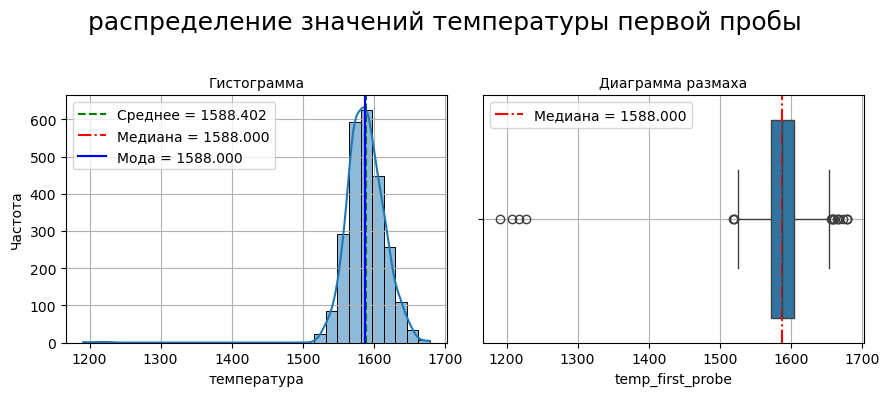

In [208]:
hist_and_box_with_stats(
    df_data_temp_merged, 
    'temp_first_probe',
    'распределение значений температуры первой пробы', 
    'температура',
    30
)

Температура плавления стали варьируется от 1370°C до 1530°C в зависимости от её состава, типа и количества легирующих элементов, таких как углерод. Различные марки стали, например, углеродистая или нержавеющая, будут плавиться при разных температурах внутри этого диапазона

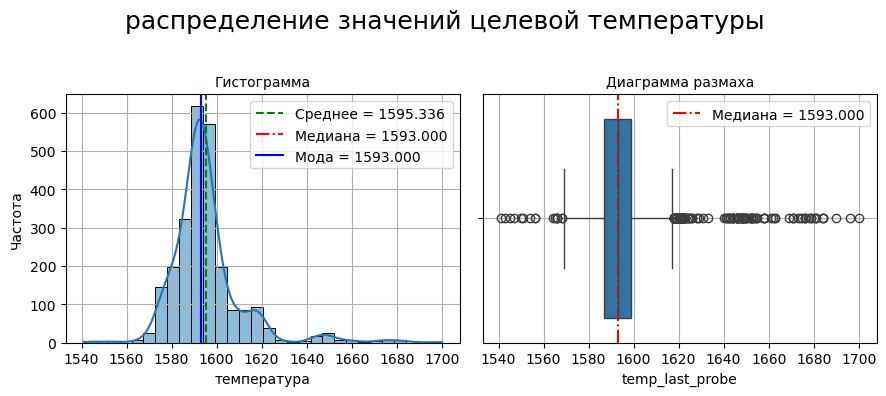

In [207]:
hist_and_box_with_stats(
    df_data_temp_merged, 
    'temp_last_probe', 
    'распределение значений целевой температуры', 
    'температура',
    30
)

Финальная температура распределена более компактно, почти без выбросов. Но всё равно температура выше необходимого порога плавления. Или это особбенности процесса плавления связанные с типом стали, или это лишний нагрев с которым нам и предстоит бороться.

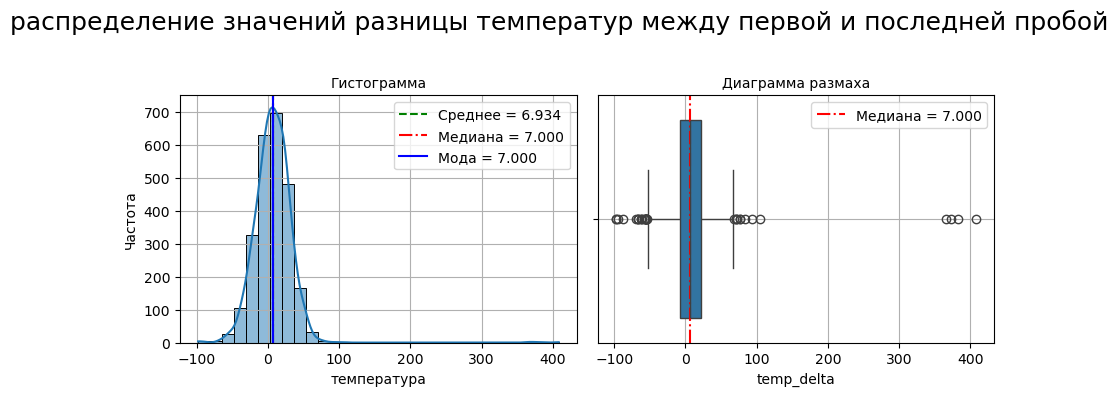

In [141]:
hist_and_box_with_stats(
    df_data_temp_merged, 
    'temp_delta',
    'распределение значений разницы температур между первой и последней пробой', 
    'температура',
    30
)

Разница температур довольно небольшая, Но есть выбросы. Скорее всего они связаны с попытками проверить температуру ещё до начала плавления.

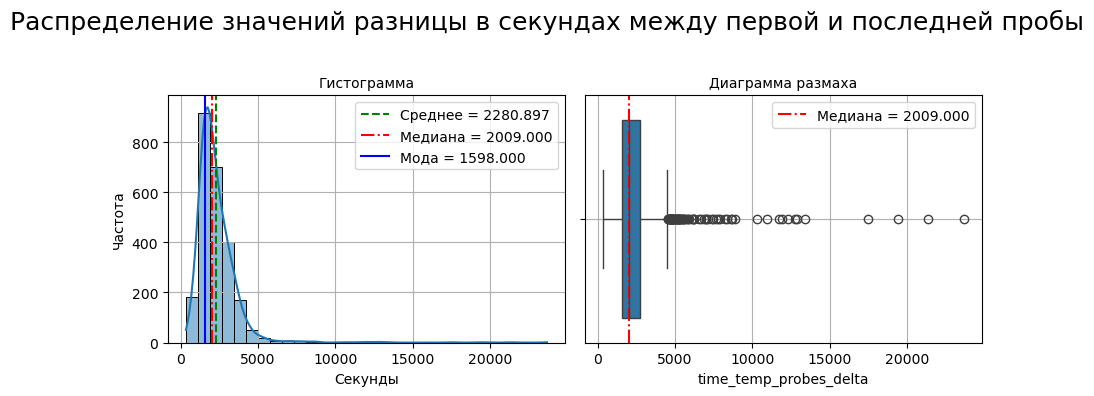

In [142]:
hist_and_box_with_stats(
    df_data_temp_merged, 
    'time_temp_probes_delta',
    'Распределение значений разницы в секундах между первой и последней пробы', 
    'Секунды',
    30
)

При медиане в 2к секунд между первым и последним замерами температуры, есть выбросы в 20к+ секунд. Разница на порядок. Посмотрим на эти партии.

In [143]:
df_data_temp_merged.sort_values(by='time_temp_probes_delta').tail()

key  count_probes time_temp_first_probe  temp_first_probe  \
9     638            12   2019-05-27 17:46:42            1588.0   
610   641             7   2019-05-28 03:43:37            1617.0   
8    1958            12   2019-07-21 09:21:56            1579.0   
0    2108            17   2019-07-27 10:41:03            1639.0   
1    1689            16   2019-07-05 08:07:11            1583.0   

    time_temp_last_probe  temp_last_probe  temp_delta  time_temp_probes_delta  
9    2019-05-27 21:30:10           1619.0        31.0                   13408  
610  2019-05-28 08:34:44           1580.0       -37.0                   17467  
8    2019-07-21 14:45:25           1570.0        -9.0                   19409  
0    2019-07-27 16:36:34           1541.0       -98.0                   21331  
1    2019-07-05 14:41:45           1606.0        23.0                   23674

Видно что было много проб температуры. Возможно это особенность технологического процесса, или проблемы с оборудованием. Например нагрев был слабее чем надо. Пока оставим эти значения.

##### Итог анализа набора данных df_data_temp

Удалены записи с пропущенными значениями температуры.
Добавлены дополнительные признаки: 
* количество температурных проб в одной партии (count_probes)
* температура первого измерения (temp_first_probe)
* температура последнего измерения температуры (temp_last_probe)
* разница между последним и первым измерением в секундах (time_temp_probes_delta)
* разница в температуре между первым и последним измерением. (temp_delta)


Сформирован набор данных df_data_temp_merged.

### Проанализируем данные об объёме проволочных материалов - data_wire

Посмотрим на пропуски.

In [144]:
df_data_wire.isnull().sum()


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

Видно что в 8 столбцах из 9 с информацией о загрузке проволочных материалов присутствует большое количество пропусков.

Посмотрим краткий анализ полученных данных.

In [145]:
df_short_view(df_data_wire)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

Т.к. в столбцах wire_Х находятся данные о количество материала, то пропуски нужно заполнить 0.

In [146]:
df_data_wire = df_data_wire.fillna(0)

In [147]:
df_full_view(df_data_wire)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

Количество явных дубликатов: 0
Количество пропусков:
 key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


key       wire_1       wire_2       wire_3       wire_4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.874524     0.261019   
std     932.996726    42.841120    33.517734    30.310417     4.293865   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     823.000000    70.281120     0.000000     0.000000     0.000000   
50%    1619.000000   100.114563     0.000000     0.000000     0.000000   
75%    2434.000000   125.798405    23.162880     0.000000     0.000000   
max    3241.000000   330.314424   282.780152   385.008668   113.231044   

            wire_5       wire_6       wire_7       wire_8       wire_9  
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000  
mean      0.004911     1.137695     0.035842     0.330697     0.321492  
std       0.272615     8.958111     0.774190     4.392677     3.806904  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max      15.132000   180.454575    32.847674   102.762401    90.053604

In [148]:
calc_percent_of_zero(df_data_wire)

В столбце key пустыми являются  0.0 % записей
В столбце wire_1 пустыми являются  0.84 % записей
В столбце wire_2 пустыми являются  64.98 % записей
В столбце wire_3 пустыми являются  97.96 % записей
В столбце wire_4 пустыми являются  99.55 % записей
В столбце wire_5 пустыми являются  99.97 % записей
В столбце wire_6 пустыми являются  97.63 % записей
В столбце wire_7 пустыми являются  99.64 % записей
В столбце wire_8 пустыми являются  99.38 % записей
В столбце wire_9 пустыми являются  99.06 % записей


Добавим признак содержащий количество добавок к одной партии.

In [149]:
filtered_cols = [col for col in df_data_wire.columns if col.startswith('wire_')]
df_data_wire['w_count'] = df_data_wire[filtered_cols].gt(0).sum(axis=1)

display(df_data_wire)

key      wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      wire_8  wire_9  w_count  
0        0.0     0.0        1  
1        0.0     0.0        1  
2        0.0     0.0        1  
3        0.0     0.0        1  
4        0.0     0.0        2  
...      ...     ...      ...  
3076     0.0     0.0        1  
3077     0.0     0.0        1  
3078     0.0     0.0        1  
3079     0.0     0.0        1  
3080     0.0     0.0        1  

[3081 rows x 11 columns]

In [150]:
df_data_wire.describe()

key       wire_1       wire_2       wire_3       wire_4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.874524     0.261019   
std     932.996726    42.841120    33.517734    30.310417     4.293865   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     823.000000    70.281120     0.000000     0.000000     0.000000   
50%    1619.000000   100.114563     0.000000     0.000000     0.000000   
75%    2434.000000   125.798405    23.162880     0.000000     0.000000   
max    3241.000000   330.314424   282.780152   385.008668   113.231044   

            wire_5       wire_6       wire_7       wire_8       wire_9  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean      0.004911     1.137695     0.035842     0.330697     0.321492   
std       0.272615     8.958111     0.774190     4.392677     3.806904   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      15.132000   180.454575    32.847674   102.762401    90.053604   

           w_count  
count  3081.000000  
mean      1.409932  
std       0.578078  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       2.000000  
max       5.000000

In [151]:
print('Kоличество уникальных значений:', len(df_data_wire['key'].unique()))

Kоличество уникальных значений: 3081


##### Посмотрим графики

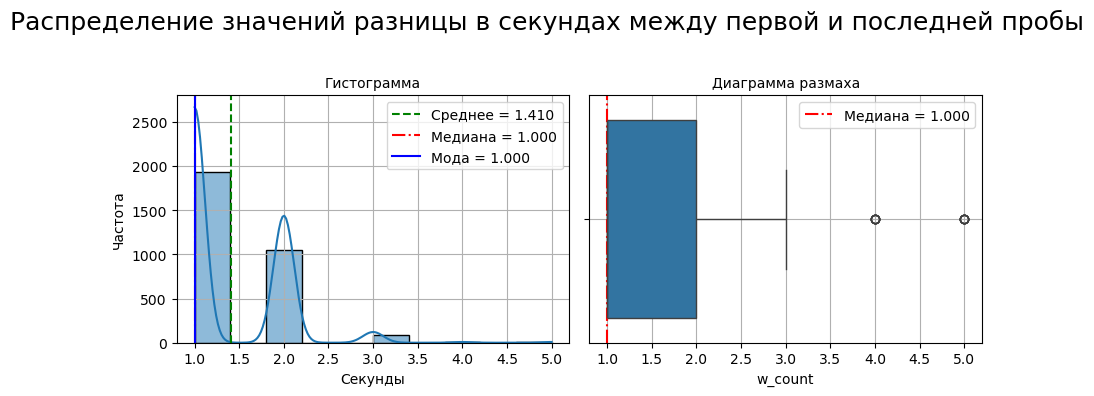

In [152]:
hist_and_box_with_stats(
    df_data_wire, 
    'w_count',
    'Распределение значений разницы в секундах между первой и последней пробы', 
    'Секунды',
    10
)

Построим графики для признаков wire_Х

In [153]:
# Находим все колонки, начинающиеся с 'bulk_'
wire_columns = [col for col in df_data_wire.columns if col.startswith('wire_')]

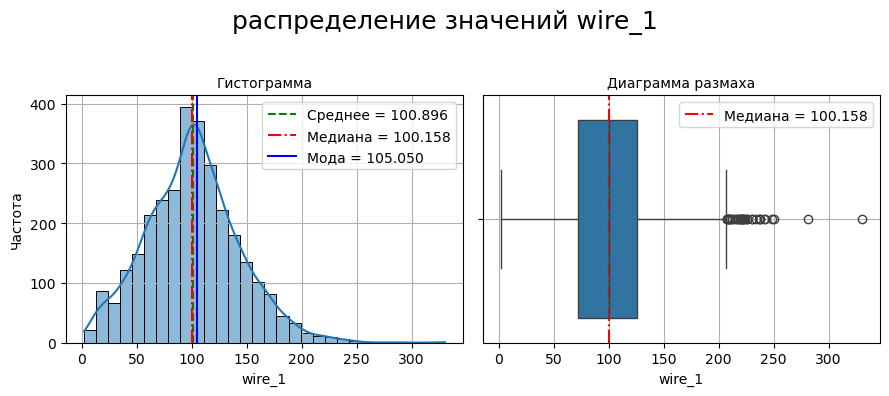

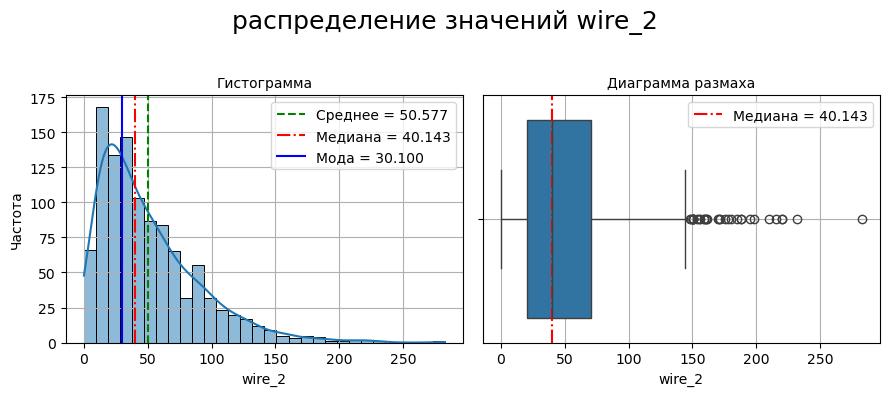

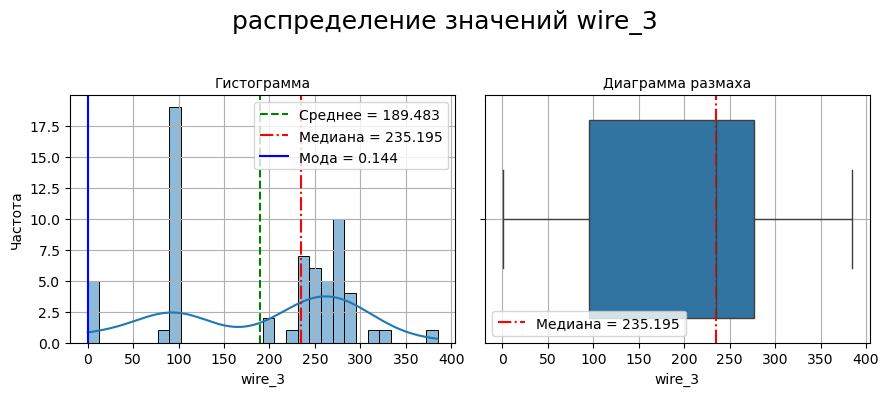

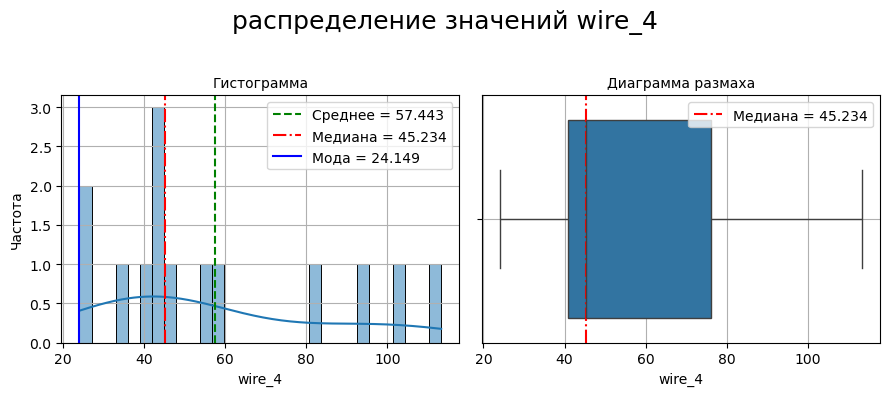

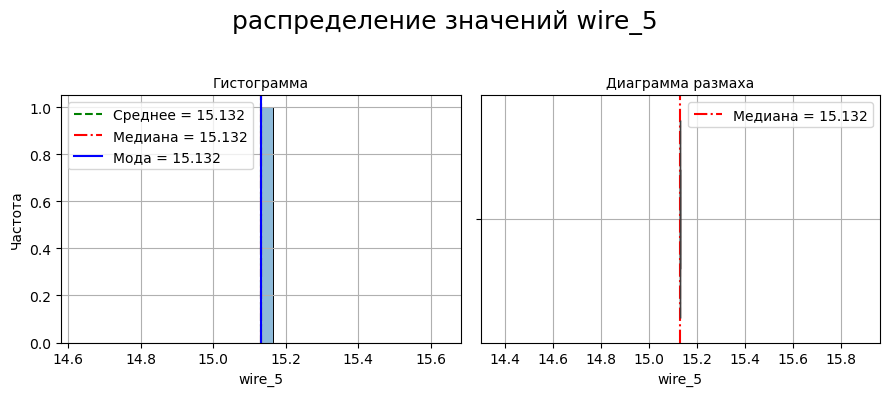

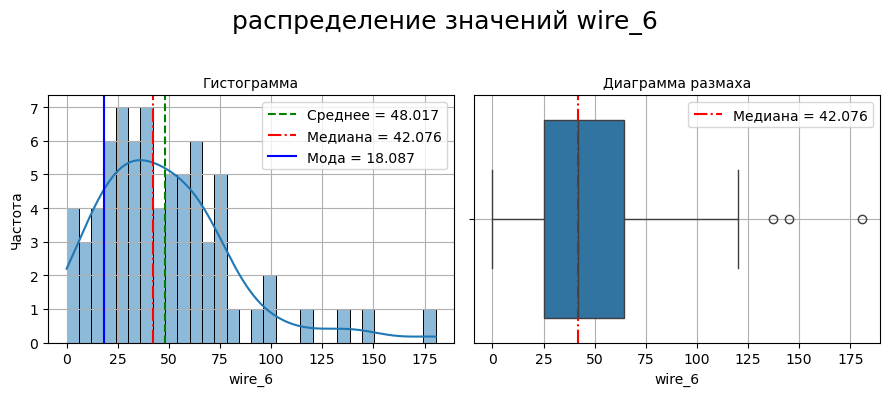

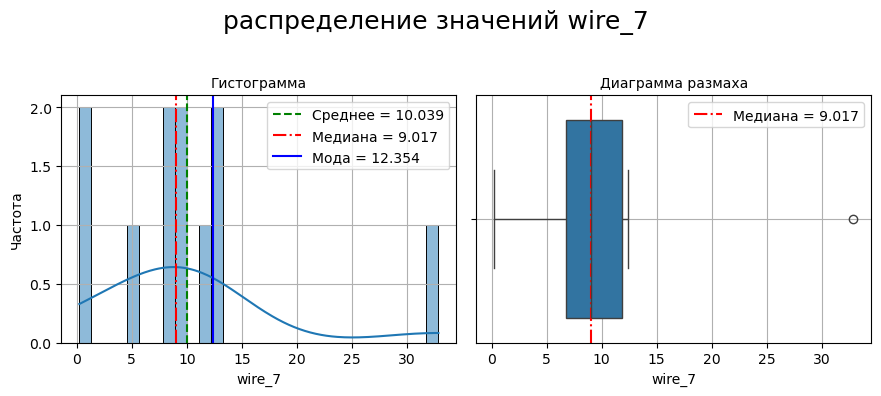

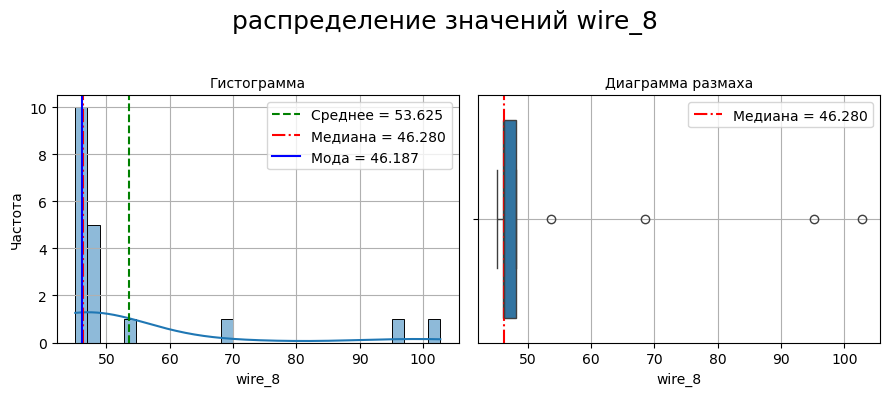

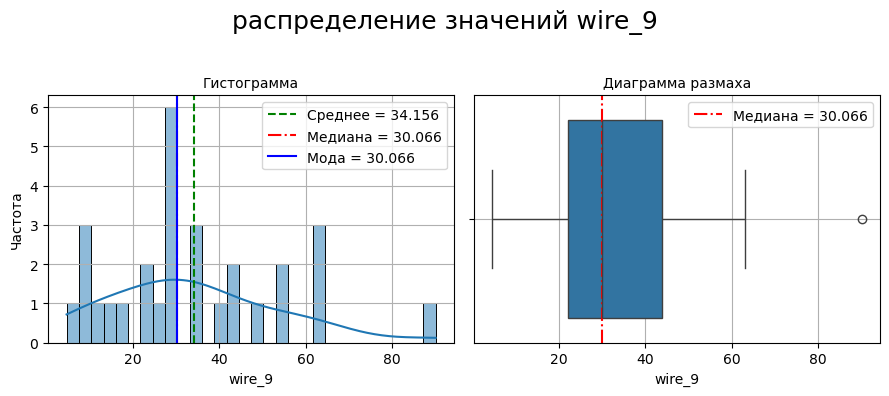

In [154]:
graph_batch (
    df_data_wire,#df,
    wire_columns, #column_list
    0 #exception
)

wire_1, wire_2, wire_6 имеют распределение похожее на нормальное, но смещённое влево.
Остальные признаки  имеют фиксированный набор значений и распределение у них очень прерывистое. Скорее всего это связано с небольшим количеством записей которые содержат такие значения.
Особенно выделяется wire_5 который имеет всего 1 значение.

##### Итог анализа набора данных df_data_wire

3081 уникальных значений партий.
Пропуски заполнены 0.

### Проанализируем данные о времени подачи проволочных материалов - data_wire_time

Посмотрим краткий анализ полученных данных.

In [155]:
df_short_view(df_data_wire_time)

Размер таблицы: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key              wire_1              wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  wire_7 wire_8 wire_9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

Добавим время начала процесса, потом посчитаем разницу между операциями подачи материала и началом процесса.

In [156]:
df_data_wire_time_added = pd.merge(
    df_data_wire_time,
    df_data_arc_grouped['начало_нагрева_дугой'], #
    left_on='key',          # столбец в левом датафрейме
    right_index=True,       # индекс в правом датафрейме
    how='left'              # тип JOIN
)
display(df_data_wire_time_added)

key              wire_1              wire_2 wire_3 wire_4 wire_5  \
0        1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT   
1        2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT   
2        3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT   
3        4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT   
4        5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT   
...    ...                 ...                 ...    ...    ...    ...   
3076  3237 2019-09-06 11:33:38                 NaT    NaT    NaT    NaT   
3077  3238 2019-09-06 12:18:35                 NaT    NaT    NaT    NaT   
3078  3239 2019-09-06 14:36:11                 NaT    NaT    NaT    NaT   
3079  3240 2019-09-06 15:33:55                 NaT    NaT    NaT    NaT   
3080  3241 2019-09-06 17:10:06                 NaT    NaT    NaT    NaT   

     wire_6 wire_7 wire_8 wire_9 начало_нагрева_дугой  
0       NaT    NaT    NaT    NaT  2019-05-03 11:02:14  
1       NaT    NaT    NaT    NaT  2019-05-03 11:34:14  
2       NaT    NaT    NaT    NaT  2019-05-03 12:06:54  
3       NaT    NaT    NaT    NaT  2019-05-03 12:39:37  
4       NaT    NaT    NaT    NaT  2019-05-03 13:11:13  
...     ...    ...    ...    ...                  ...  
3076    NaT    NaT    NaT    NaT  2019-09-06 11:31:25  
3077    NaT    NaT    NaT    NaT  2019-09-06 12:16:25  
3078    NaT    NaT    NaT    NaT  2019-09-06 14:17:00  
3079    NaT    NaT    NaT    NaT  2019-09-06 15:25:31  
3080    NaT    NaT    NaT    NaT  2019-09-06 16:49:05  

[3081 rows x 11 columns]

Посчитаем временную разницу.

In [157]:
wire_columns = [col for col in df_data_wire_time_added.columns if col.startswith('wire_')]

In [158]:
df_data_wire_time_added = delta_calculation(df_data_wire_time_added, wire_columns, 'начало_нагрева_дугой')

Создан столбец wire_1_diff
Создан столбец wire_2_diff
Создан столбец wire_3_diff
Создан столбец wire_4_diff
Создан столбец wire_5_diff
Создан столбец wire_6_diff
Создан столбец wire_7_diff
Создан столбец wire_8_diff
Создан столбец wire_9_diff


In [159]:
# удалим ненужные исходные признаки.
df_data_wire_time_diff = df_data_wire_time_added.drop(columns =  wire_columns)

In [160]:
display(df_data_wire_time_diff)

key начало_нагрева_дугой  wire_1_diff  wire_2_diff  wire_3_diff  \
0        1  2019-05-03 11:02:14        245.0          0.0          0.0   
1        2  2019-05-03 11:34:14        156.0          0.0          0.0   
2        3  2019-05-03 12:06:54        292.0          0.0          0.0   
3        4  2019-05-03 12:39:37        225.0          0.0          0.0   
4        5  2019-05-03 13:11:13        571.0        261.0          0.0   
...    ...                  ...          ...          ...          ...   
3076  3237  2019-09-06 11:31:25        133.0          0.0          0.0   
3077  3238  2019-09-06 12:16:25        130.0          0.0          0.0   
3078  3239  2019-09-06 14:17:00       1151.0          0.0          0.0   
3079  3240  2019-09-06 15:25:31        504.0          0.0          0.0   
3080  3241  2019-09-06 16:49:05       1261.0          0.0          0.0   

      wire_4_diff  wire_5_diff  wire_6_diff  wire_7_diff  wire_8_diff  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          0.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
3076          0.0          0.0          0.0          0.0          0.0   
3077          0.0          0.0          0.0          0.0          0.0   
3078          0.0          0.0          0.0          0.0          0.0   
3079          0.0          0.0          0.0          0.0          0.0   
3080          0.0          0.0          0.0          0.0          0.0   

      wire_9_diff  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
3076          0.0  
3077          0.0  
3078          0.0  
3079          0.0  
3080          0.0  

[3081 rows x 11 columns]

In [161]:
print('Kоличество уникальных значений:', len(df_data_wire_time_diff['key'].unique()))

Kоличество уникальных значений: 3081


##### Построим графики

Отберём подходящие столбцы.

In [162]:
# Находим все колонки, начинающиеся с 'wire_'
wire_columns = [col for col in df_data_wire_time_diff.columns if col.startswith('wire_')]

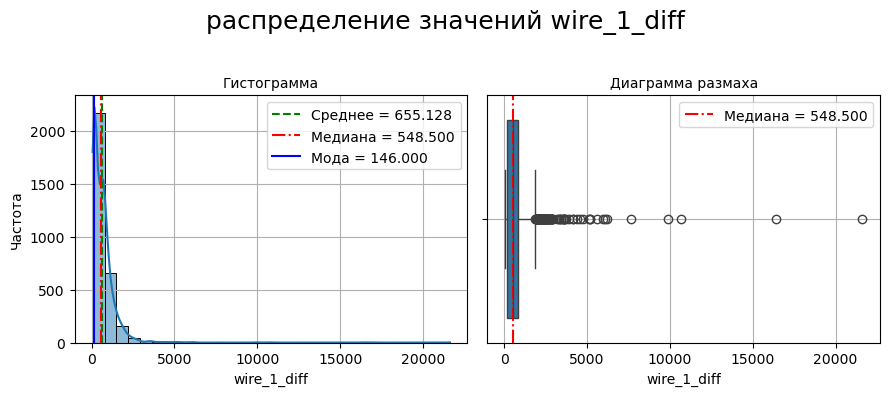

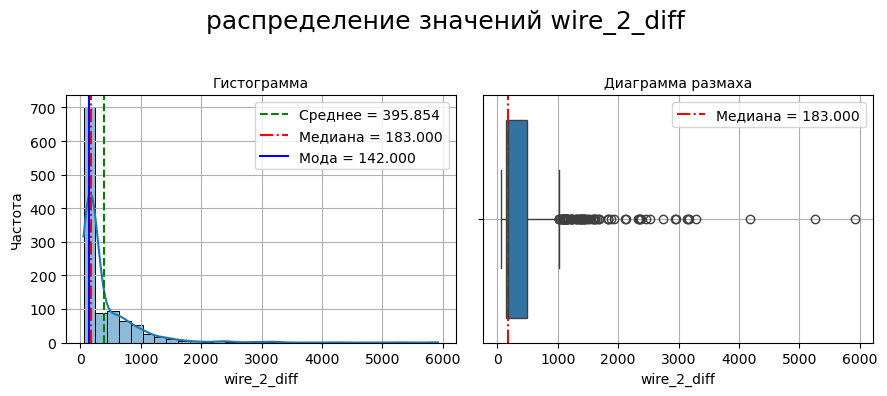

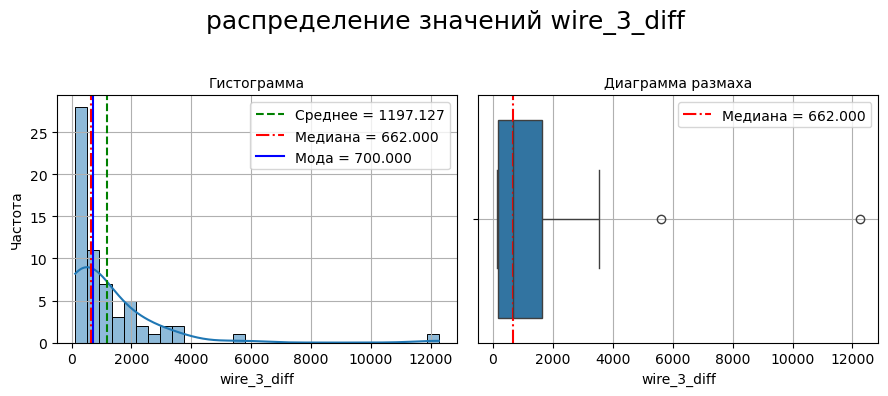

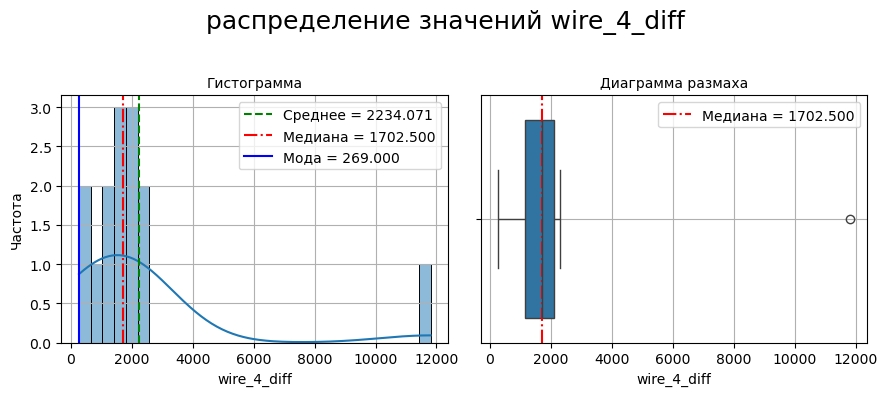

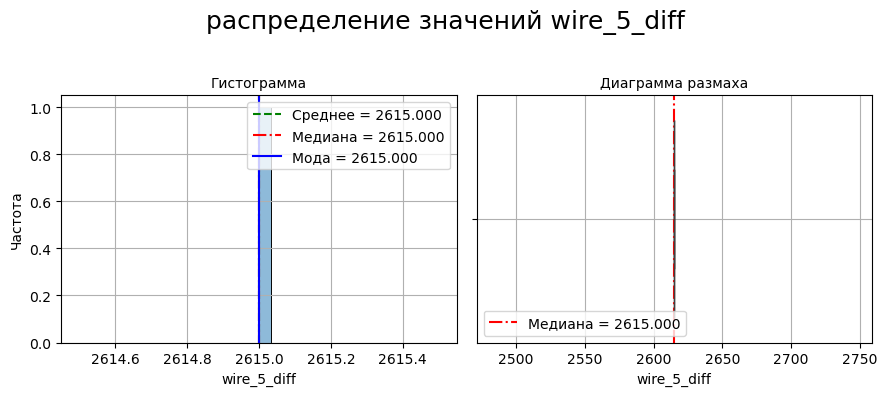

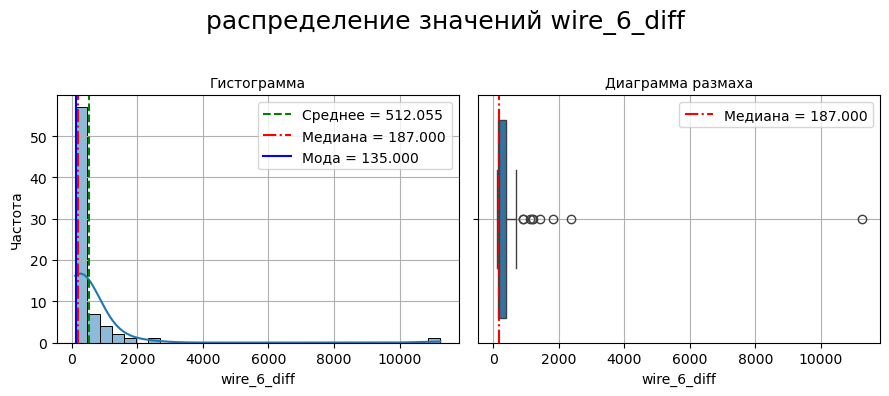

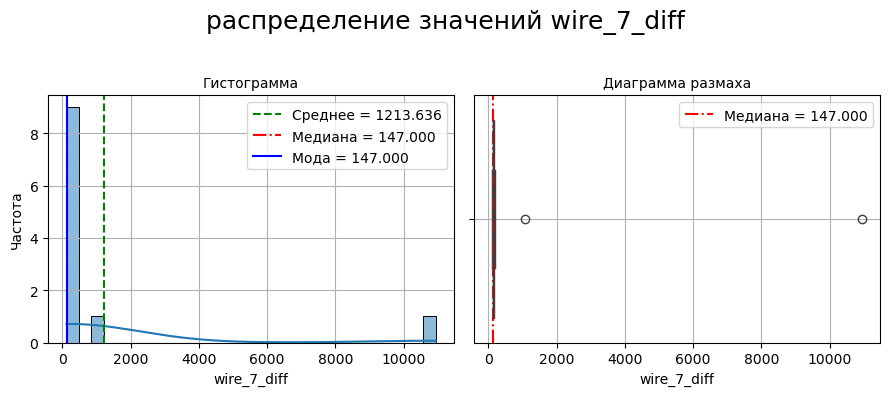

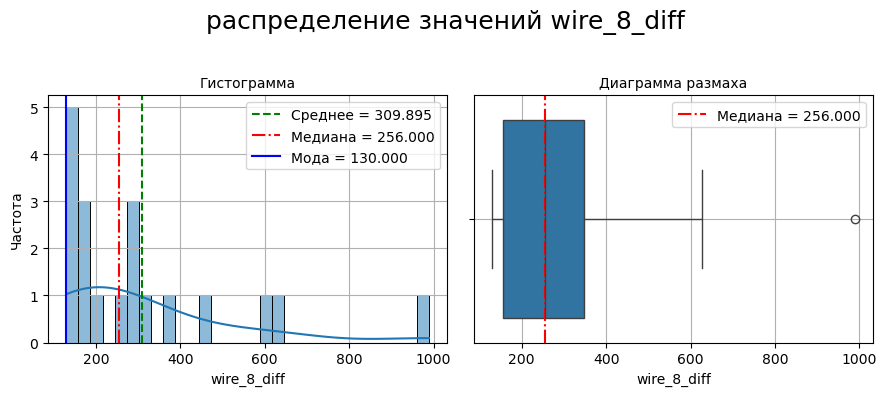

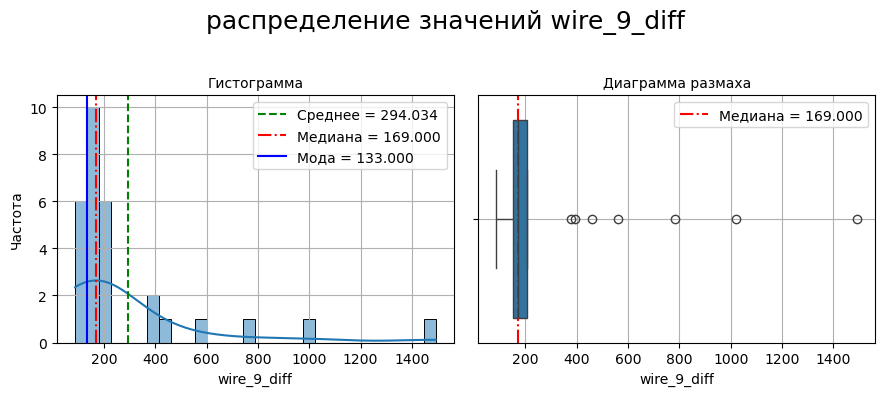

In [163]:
graph_batch (
    df_data_wire_time_diff,#df,
    wire_columns, #column_list
    0 #exception
)

Есть отдельные аномалии которые больше чем на порядок превышают значениямедианы, но т.к. непустых записей очень мало, мы эти значения пока оставим.

##### Итог анализа набора данных df_data_wire_time

3081 уникальных значений партий.
Добавлены признаки содержащие разницу в секунда между добавлением материала и началом процесса. Есть аномальные значения которые сильно выделяются. Их пока оставили в наборе.

## Подготовим итоговую таблицу для начала обучения моделей.

Объеденим данные о электродах и данные о времени засыпки материала.

In [164]:
################################################
display(df_data_arc_grouped.info())
display(df_data_arc_grouped.head())


display(df_data_bulk_droped.info())
display(df_data_bulk_droped.head())
###############################################

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   count_heat            3214 non-null   int64         
 1   начало_нагрева_дугой  3214 non-null   datetime64[ns]
 2   конец_нагрева_дугой   3214 non-null   datetime64[ns]
 3   активная_мощность     3214 non-null   float64       
 4   реактивная_мощность   3214 non-null   float64       
 5   time_delta_heat       3214 non-null   int32         
 6   common_power          3214 non-null   float64       
 7   coeff_power           3214 non-null   float64       
 8   total_energy          3214 non-null   float64       
 9   time_delta_heat_mean  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1)
memory usage: 263.6 KB


None

count_heat начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
key                                                                           
1             5  2019-05-03 11:02:14 2019-05-03 11:28:37           0.607346   
2             4  2019-05-03 11:34:14 2019-05-03 11:53:18           0.534852   
3             5  2019-05-03 12:06:54 2019-05-03 12:32:19           0.812728   
4             4  2019-05-03 12:39:37 2019-05-03 12:57:50           0.676622   
5             4  2019-05-03 13:11:13 2019-05-03 13:33:55           0.563238   

     реактивная_мощность  time_delta_heat  common_power  coeff_power  \
key                                                                    
1               0.428564             1098      3.718736     0.706569   
2               0.363339              811      2.588349     0.684080   
3               0.587491              655      5.019223     0.725034   
4               0.514248              741      3.400038     0.765897   
5               0.421998              869      2.816980     0.758599   

     total_energy  time_delta_heat_mean  
key                                      
1      770.282114                219.60  
2      481.760005                202.75  
3      722.837668                131.00  
4      683.455597                185.25  
5      512.169934                217.25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_3   3129 non-null   float64
 3   bulk_4   3129 non-null   float64
 4   bulk_5   3129 non-null   float64
 5   bulk_6   3129 non-null   float64
 6   bulk_10  3129 non-null   float64
 7   bulk_11  3129 non-null   float64
 8   bulk_12  3129 non-null   float64
 9   bulk_14  3129 non-null   float64
 10  bulk_15  3129 non-null   float64
 11  b_count  3129 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 293.5 KB


None

key  bulk_1  bulk_3  bulk_4  bulk_5  bulk_6  bulk_10  bulk_11  bulk_12  \
0    1     0.0     0.0    43.0     0.0     0.0      0.0      0.0    206.0   
1    2     0.0     0.0    73.0     0.0     0.0      0.0      0.0    206.0   
2    3     0.0     0.0    34.0     0.0     0.0      0.0      0.0    205.0   
3    4     0.0     0.0    81.0     0.0     0.0      0.0      0.0    207.0   
4    5     0.0     0.0    78.0     0.0     0.0      0.0      0.0    203.0   

   bulk_14  bulk_15  b_count  
0    150.0    154.0        4  
1    149.0    154.0        4  
2    152.0    153.0        4  
3    153.0    154.0        4  
4    151.0    152.0        4

In [165]:
df_result_merged = pd.merge(
    df_data_arc_grouped, #
    df_data_bulk_droped,
    right_on='key',          # столбец в левом датафрейме
    left_index=True,       # индекс в правом датафрейме
    how='left'              # тип JOIN
)

Добавим данные о количестве сыпучих материалов

Добавим данные о продувке газом

In [166]:
df_result_merged = pd.merge(
    df_result_merged, #
    df_data_gas,
    right_on='key',          # столбец в левом датафрейме
    left_on='key',       # индекс в правом датафрейме
    how='inner'              # тип JOIN
)


Добавим данные о замерах температуры

In [167]:
df_result_merged = pd.merge(
    df_result_merged, #
    df_data_temp_merged,
    right_on='key',          # столбец в левом датафрейме
    left_on='key',       # индекс в правом датафрейме
    how='inner'              # тип JOIN
)


Добавим данные об объёме проволочных материалов

In [168]:
df_result_merged = pd.merge(
    df_result_merged, #
    df_data_wire,
    right_on='key',          # столбец в левом датафрейме
    left_on='key',       # индекс в правом датафрейме
    how='inner'              # тип JOIN
)

Добавим данные о времени подачи проволочных материалов

In [169]:
df_result_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371 entries, 0 to 2370
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   count_heat              2371 non-null   int64         
 1   начало_нагрева_дугой    2371 non-null   datetime64[ns]
 2   конец_нагрева_дугой     2371 non-null   datetime64[ns]
 3   активная_мощность       2371 non-null   float64       
 4   реактивная_мощность     2371 non-null   float64       
 5   time_delta_heat         2371 non-null   int32         
 6   common_power            2371 non-null   float64       
 7   coeff_power             2371 non-null   float64       
 8   total_energy            2371 non-null   float64       
 9   time_delta_heat_mean    2371 non-null   float64       
 10  key                     2371 non-null   int64         
 11  bulk_1                  2329 non-null   float64       
 12  bulk_3                  2329 non-null   float64 

##### Сделаем поле KEY  индексом

In [170]:
df_result_merged = df_result_merged.set_index('key')
df_result_merged.head()

count_heat начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
key                                                                           
1             5  2019-05-03 11:02:14 2019-05-03 11:28:37           0.607346   
2             4  2019-05-03 11:34:14 2019-05-03 11:53:18           0.534852   
3             5  2019-05-03 12:06:54 2019-05-03 12:32:19           0.812728   
4             4  2019-05-03 12:39:37 2019-05-03 12:57:50           0.676622   
5             4  2019-05-03 13:11:13 2019-05-03 13:33:55           0.563238   

     реактивная_мощность  time_delta_heat  common_power  coeff_power  \
key                                                                    
1               0.428564             1098      3.718736     0.706569   
2               0.363339              811      2.588349     0.684080   
3               0.587491              655      5.019223     0.725034   
4               0.514248              741      3.400038     0.765897   
5               0.421998              869      2.816980     0.758599   

     total_energy  time_delta_heat_mean  ...     wire_1   wire_2  wire_3  \
key                                      ...                               
1      770.282114                219.60  ...  60.059998  0.00000     0.0   
2      481.760005                202.75  ...  96.052315  0.00000     0.0   
3      722.837668                131.00  ...  91.160157  0.00000     0.0   
4      683.455597                185.25  ...  89.063515  0.00000     0.0   
5      512.169934                217.25  ...  89.238236  9.11456     0.0   

     wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  w_count  
key                                                           
1       0.0     0.0     0.0     0.0     0.0     0.0        1  
2       0.0     0.0     0.0     0.0     0.0     0.0        1  
3       0.0     0.0     0.0     0.0     0.0     0.0        1  
4       0.0     0.0     0.0     0.0     0.0     0.0        1  
5       0.0     0.0     0.0     0.0     0.0     0.0        2  

[5 rows x 39 columns]

##### Удалим признаки которые были синтезированны , но неизвестны до завершения процедуры

In [171]:
df_result_merged = df_result_merged.drop(columns=[
    'temp_delta',
    'time_delta_heat_mean', 
    'time_delta_heat',
]
                                        )

In [172]:
display(df_result_merged.columns)

Index(['count_heat', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность', 'common_power',
       'coeff_power', 'total_energy', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15',
       'b_count', 'газ_1', 'count_probes', 'time_temp_first_probe',
       'temp_first_probe', 'time_temp_last_probe', 'temp_last_probe',
       'time_temp_probes_delta', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'w_count'],
      dtype='object')

### Посмотрим матрицу корреляций

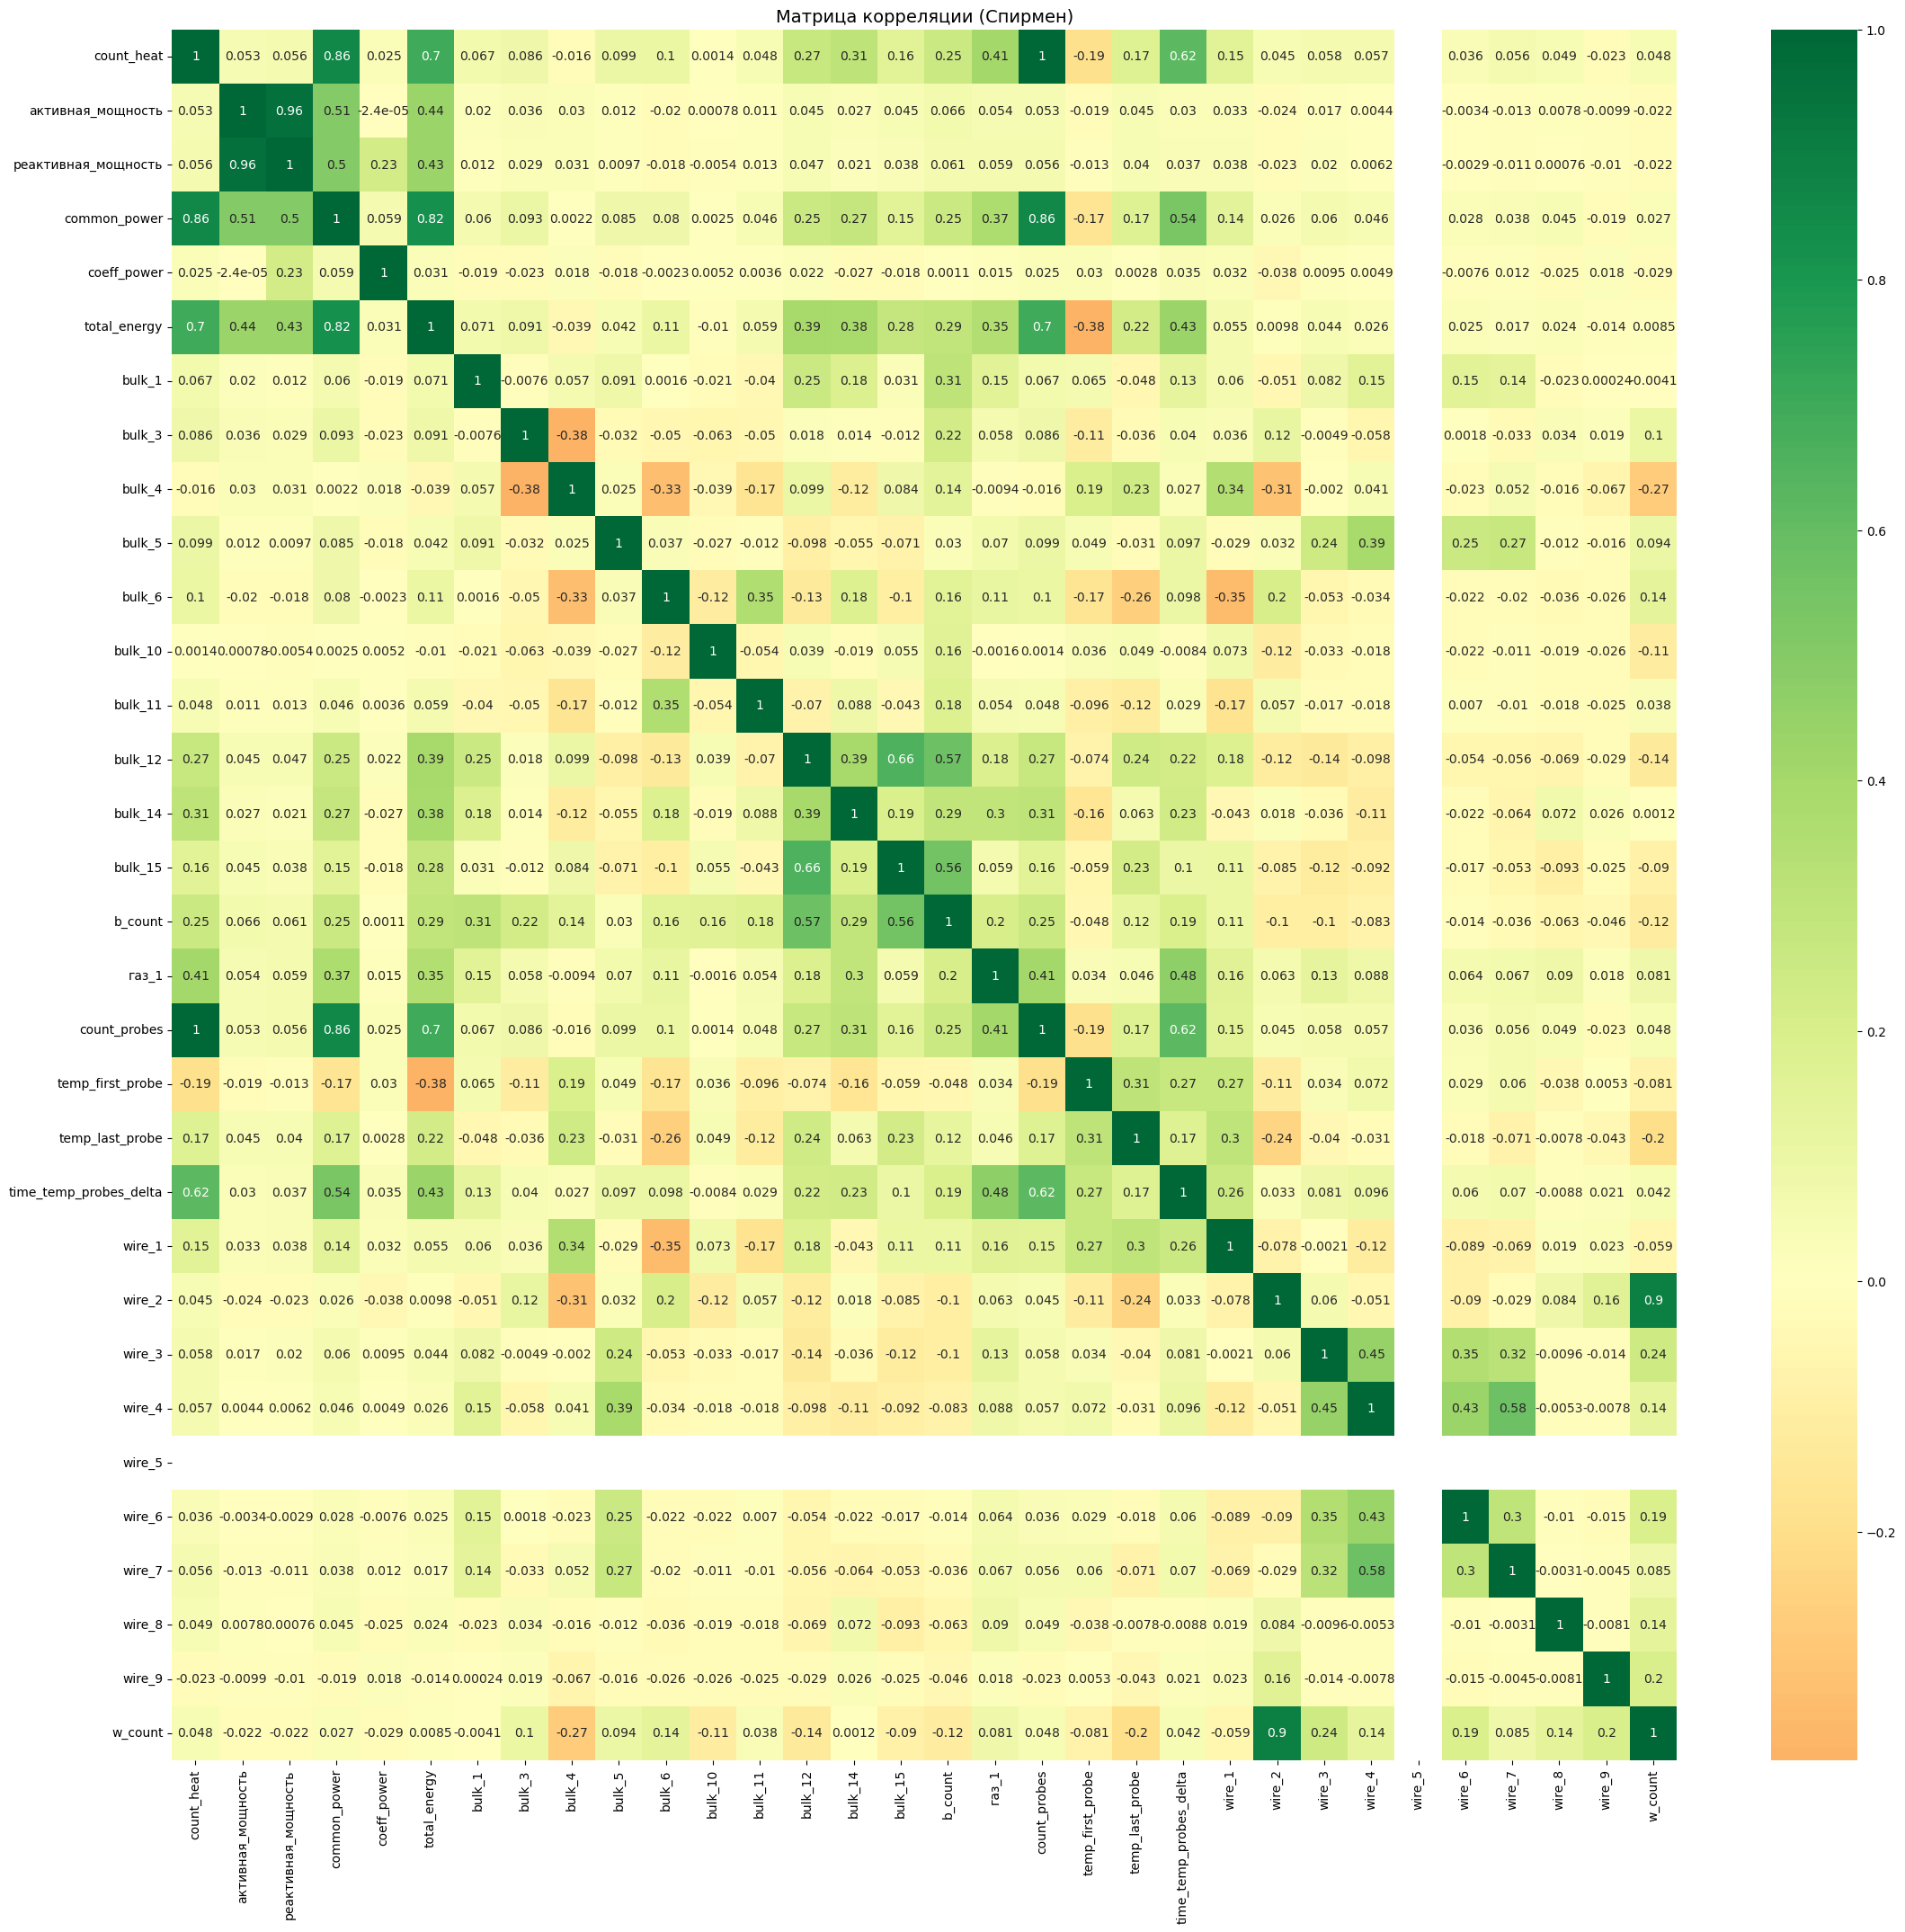

In [173]:
corr_heatmap(df_result_merged, 27,25, 'spearman', drop_columns=['key'])

При таком количестве признаков ничего нельзя рассмотреть. Или надо уменьшать количество удаляя пустые на 99%. Или группировать и устранять исходные признаки.
Но мультиколинеарность виднеется.

### Посмотрим на PHI_K. 

Отберём нужные данные.

In [174]:
#!pip3 install phik
import phik
# отберём чистовые столбцы, отбросим даты
numeric_cols= df_result_merged.select_dtypes(include='number').columns.tolist()
non_constant_cols = [col for col in numeric_cols if df_result_merged[col].nunique() > 1]

df_sample = df_result_merged[non_constant_cols]#.sample(2000)

display(df_sample.head(5))

count_heat  активная_мощность  реактивная_мощность  common_power  \
key                                                                     
1             5           0.607346             0.428564      3.718736   
2             4           0.534852             0.363339      2.588349   
3             5           0.812728             0.587491      5.019223   
4             4           0.676622             0.514248      3.400038   
5             4           0.563238             0.421998      2.816980   

     coeff_power  total_energy  bulk_1  bulk_3  bulk_4  bulk_5  ...  \
key                                                             ...   
1       0.706569    770.282114     0.0     0.0    43.0     0.0  ...   
2       0.684080    481.760005     0.0     0.0    73.0     0.0  ...   
3       0.725034    722.837668     0.0     0.0    34.0     0.0  ...   
4       0.765897    683.455597     0.0     0.0    81.0     0.0  ...   
5       0.758599    512.169934     0.0     0.0    78.0     0.0  ...   

     time_temp_probes_delta     wire_1   wire_2  wire_3  wire_4  wire_6  \
key                                                                       
1                      1714  60.059998  0.00000     0.0     0.0     0.0   
2                      1265  96.052315  0.00000     0.0     0.0     0.0   
3                      1753  91.160157  0.00000     0.0     0.0     0.0   
4                      1220  89.063515  0.00000     0.0     0.0     0.0   
5                      1536  89.238236  9.11456     0.0     0.0     0.0   

     wire_7  wire_8  wire_9  w_count  
key                                   
1       0.0     0.0     0.0        1  
2       0.0     0.0     0.0        1  
3       0.0     0.0     0.0        1  
4       0.0     0.0     0.0        1  
5       0.0     0.0     0.0        2  

[5 rows x 31 columns]

Построим результирующую таблицу с данными PHI_k

In [175]:
#phik_overview = df_sample.phik_matrix(interval_cols=num_cols)
#display(phik_overview)
try:
    phik_overview = df_sample[non_constant_cols].phik_matrix(
        bins=10,  # меньше бинов
        quantile=False,
        verbose=True,
        interval_cols=non_constant_cols
    )
    display(phik_overview)
    
except ValueError as e:
    print(f"Phik не сработал: {e}")


count_heat  активная_мощность  реактивная_мощность  \
count_heat                1.000000           0.298112             0.316736   
активная_мощность         0.298112           1.000000             0.958646   
реактивная_мощность       0.316736           0.958646             1.000000   
common_power              0.951019           0.548651             0.544888   
coeff_power               0.295209           0.082295             0.310966   
total_energy              0.734637           0.327346             0.329661   
bulk_1                    0.000000           0.000000             0.000000   
bulk_3                    0.082294           0.000000             0.000000   
bulk_4                    0.000000           0.000000             0.000000   
bulk_5                    0.123664           0.000000             0.000000   
bulk_6                    0.224435           0.000000             0.000000   
bulk_10                   0.000000           0.000000             0.000000   
bulk_11                   0.000000           0.000000             0.000000   
bulk_12                   0.507543           0.088597             0.091075   
bulk_14                   0.368600           0.074608             0.052607   
bulk_15                   0.181248           0.000000             0.000000   
b_count                   0.000000           0.000000             0.000000   
газ_1                     0.593322           0.036080             0.079305   
count_probes              1.000000           0.298107             0.316736   
temp_first_probe          0.294467           0.066337             0.044893   
temp_last_probe           0.361435           0.000000             0.000000   
time_temp_probes_delta    0.677653           0.000000             0.000000   
wire_1                    0.174917           0.099253             0.059869   
wire_2                    0.311622           0.154264             0.142751   
wire_3                    0.197769           0.000000             0.000000   
wire_4                    0.419925           0.000000             0.000000   
wire_6                    0.143133           0.000000             0.000000   
wire_7                    0.513373           0.000000             0.000000   
wire_8                    0.000000           0.051636             0.000000   
wire_9                    0.000000           0.000000             0.000000   
w_count                   0.337841           0.000000             0.000000   

                        common_power  coeff_power  total_energy    bulk_1  \
count_heat                  0.951019     0.295209      0.734637  0.000000   
активная_мощность           0.548651     0.082295      0.327346  0.000000   
реактивная_мощность         0.544888     0.310966      0.329661  0.000000   
common_power                1.000000     0.271758      0.798440  0.000000   
coeff_power                 0.271758     1.000000      0.116867  0.000000   
total_energy                0.798440     0.116867      1.000000  0.000000   
bulk_1                      0.000000     0.000000      0.000000  1.000000   
bulk_3                      0.000000     0.000000      0.070808  0.767998   
bulk_4                      0.000000     0.000000      0.040550  0.718247   
bulk_5                      0.262201     0.000000      0.000000  0.941135   
bulk_6                      0.234791     0.000000      0.240691  0.768122   
bulk_10                     0.000000     0.000000      0.000000  0.943111   
bulk_11                     0.000000     0.000000      0.000000  0.717624   
bulk_12                     0.539497     0.055031      0.574536  0.477589   
bulk_14                     0.285062     0.033472      0.509220  0.769662   
bulk_15                     0.141956     0.000000      0.192113  0.941148   
b_count                     0.000000     0.000000      0.000000  1.000000   
газ_1                       0.572057     0.000000      0.402120  0.112828   
count_probes                0.951018     0.295209      0.734824 

Посмотрим на признаки которые оказывают влияние на целевой признак.

In [176]:
display(phik_overview['temp_last_probe'].loc[ phik_overview['temp_last_probe'] > 0.05].sort_values(ascending=False).head(10))

temp_last_probe           1.000000
w_count                   0.823471
wire_4                    0.647998
wire_7                    0.599794
wire_3                    0.549314
wire_6                    0.512962
common_power              0.486768
wire_1                    0.468947
time_temp_probes_delta    0.420198
bulk_5                    0.401492
Name: temp_last_probe, dtype: float64

Видим что итоговая температура сильнее всего зависит от:
* первоначальной температуры
* количества температурных проб
* сыпущего материала под кодовым обозначением **bulk_14**
* проволочного материала под кодовыми обозначением **wire_1**  **wire_4** и **wire_3**
* количества энергии потраченной на нагрев
* количества нагреваний.

Посмотрим на признаки оказывающие наименьшее влияние на итоговую температуру.

In [177]:
display(phik_overview['temp_last_probe'].sort_values(ascending=True).head(10))

активная_мощность      0.000000
реактивная_мощность    0.000000
bulk_1                 0.000000
coeff_power            0.000000
bulk_3                 0.000000
wire_8                 0.000000
wire_9                 0.000000
b_count                0.000000
bulk_10                0.052695
bulk_11                0.089219
Name: temp_last_probe, dtype: float64

### Посмотрим на cильно коррелирующие пары признаков

In [178]:
phik_overview.unstack()[(phik_overview.unstack() < 1) & (abs(phik_overview.unstack()) > 0.9)]

count_heat           common_power           0.951019
активная_мощность    реактивная_мощность    0.958646
реактивная_мощность  активная_мощность      0.958646
common_power         count_heat             0.951019
                     count_probes           0.951018
bulk_1               bulk_5                 0.941135
                     bulk_10                0.943111
                     bulk_15                0.941148
bulk_5               bulk_1                 0.941135
                     bulk_10                0.941190
bulk_10              bulk_1                 0.943111
                     bulk_5                 0.941190
                     bulk_15                0.941502
bulk_15              bulk_1                 0.941148
                     bulk_10                0.941502
count_probes         common_power           0.951018
wire_4               wire_7                 0.995909
wire_7               wire_4                 0.995909
dtype: float64

Следующие признаки можно удалить т.к. у них есть явная взаимосвязь между собой и они просту дублируют друг друга. Это не увеличивает точность модели, но её приходится обсчитывать дополнительные данные.

Можно удалить:
* реактивная_мощность  - коррелирует с активная_мощность
* bulk_5   - коррелирует с  bulk_1
* bulk_10   - коррелирует с  bulk_1
* bulk_15   - коррелирует с  bulk_1
* wire_7   - коррелирует с  wire_4

In [179]:
df_result_merged = df_result_merged.drop(columns=['реактивная_мощность','bulk_5','bulk_10','bulk_15','wire_7'])

## Подготовим остальные данные для  обучения

### Определимся с необходимыми признаками

Посмотрим список численных признаков

In [180]:
display(df_result_merged.select_dtypes(include='number').columns.tolist())

['count_heat',
 'активная_мощность',
 'common_power',
 'coeff_power',
 'total_energy',
 'bulk_1',
 'bulk_3',
 'bulk_4',
 'bulk_6',
 'bulk_11',
 'bulk_12',
 'bulk_14',
 'b_count',
 'газ_1',
 'count_probes',
 'temp_first_probe',
 'temp_last_probe',
 'time_temp_probes_delta',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_5',
 'wire_6',
 'wire_8',
 'wire_9',
 'w_count']

Посмотрим список временных признаков

In [181]:
display(df_result_merged.select_dtypes(include='datetime64').columns.tolist())

['начало_нагрева_дугой',
 'конец_нагрева_дугой',
 'time_temp_first_probe',
 'time_temp_last_probe']

Удалим признаки времени, они не участвуют в обучении моделей.

In [182]:
df_result_cleared = df_result_merged.drop(columns = df_result_merged.select_dtypes(include='datetime64').columns.tolist())

df_result_cleared.info()

### Разделим данные на тренеровочные и тестовый набор данных.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    df_result_cleared.drop(columns=['temp_last_probe']), 
    df_result_cleared['temp_last_probe'], 
    test_size=0.25, 
    random_state=RANDOM_STATE
)
#  Преобразование к float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [184]:
# Проверим размеры получившихся выборок
print('Размер тренировочной выборки:', X_train.shape)
#print('Размер валидационной выборки:', X_valid.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape)
#print('Размер выборки для целевых признаков валидационной выборки:', y_valid.shape)
print('Размер выборки для целевых признаков тестовой выборки:', y_test.shape)

Размер тренировочной выборки: (1778, 26)
Размер тестовой выборки: (593, 26)
Размер выборки для целевых признаков тренировочной выборки: (1778,)
Размер выборки для целевых признаков тестовой выборки: (593,)


In [185]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()

print('num_columns       ')
display(num_columns)
print('')


num_columns       


['count_heat',
 'активная_мощность',
 'common_power',
 'coeff_power',
 'total_energy',
 'bulk_1',
 'bulk_3',
 'bulk_4',
 'bulk_6',
 'bulk_11',
 'bulk_12',
 'bulk_14',
 'b_count',
 'газ_1',
 'count_probes',
 'temp_first_probe',
 'time_temp_probes_delta',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_5',
 'wire_6',
 'wire_8',
 'wire_9',
 'w_count']

In [186]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
#    ('scaler', StandardScaler())
    
])
data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
], remainder='passthrough')

In [187]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostRegressor())
    ]
)
param_grid = [
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
        'models__learning_rate': [0.01, 0.1, 0.3],
        'models__iterations': [250 , 500 , 1000],             
    },
    
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 250, 500, 750],
        'models__max_features': ['sqrt', 'log2'],
    },
    {
        'models': [ElasticNet(
           #                     random_state=RANDOM_STATE, 
                                max_iter= 5000,
                                )],
#        'models__C': [0.1, 1, 10],
        'models__l1_ratio': [0.1, 0.25,  0.5, 0.75, 1]
    },
]

## Проверим обычные регресии

In [188]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring=['neg_mean_absolute_error', 'r2'],  # Для регрессии
    refit = 'neg_mean_absolute_error',      
    n_iter=iter_num,
    verbose = 1,    # уровень логирования
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [189]:
%%time
randomized_search.fit(X_train, y_train)

print('Лучшая модель:', randomized_search.best_estimator_)
print('Параметры лучшей модели:', randomized_search.best_params_)
print('Метрика MAE на тренировочных данных:', abs(round(randomized_search.best_score_,4)))
print('')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['count_heat',
                                                   'активная_мощность',
                                                   'common_power',
                                                   'coeff_power',
                                                   'total_energy', 'bulk_1',
                                                   'bulk_3', 'bulk_4', 'bulk_6',
                    

In [190]:
df_result_RandomizedSearchCV = pd.DataFrame(randomized_search.cv_results_)#
# Для конкретных столбцов
df_result_RandomizedSearchCV['mean_test_MAE'] = np.abs(df_result_RandomizedSearchCV['mean_test_neg_mean_absolute_error'])

display(df_result_RandomizedSearchCV[['rank_test_neg_mean_absolute_error', 'mean_test_MAE', 'mean_test_r2', 'mean_fit_time','param_models' ]].sort_values(by = 'rank_test_neg_mean_absolute_error', ascending=True))

#display(df_result)
#display(df_result_RandomizedSearchCV.columns)

rank_test_neg_mean_absolute_error  mean_test_MAE  mean_test_r2  \
3                                   1       6.245769      0.424934   
9                                   2       6.306226      0.417167   
14                                  3       6.560403      0.381577   
8                                   4       6.600333      0.360811   
5                                   5       6.616390      0.372169   
2                                   6       6.630104      0.370605   
7                                   7       6.707170      0.344417   
11                                  8       6.714571      0.344664   
13                                  9       6.753211      0.337440   
4                                  10       6.762327      0.335207   
1                                  11       6.811435      0.324572   
0                                  12       6.867930      0.307548   
10                                 13       8.156563      0.010442   
12                                 14       8.191745      0.002468   
6                                  15       8.239805     -0.009094   

    mean_fit_time                                       param_models  
3        1.933191  <catboost.core.CatBoostRegressor object at 0x7...  
9        4.167152  <catboost.core.CatBoostRegressor object at 0x7...  
14       1.269172  <catboost.core.CatBoostRegressor object at 0x7...  
8        2.882424  <catboost.core.CatBoostRegressor object at 0x7...  
5        2.966060  <catboost.core.CatBoostRegressor object at 0x7...  
2        7.840314  <catboost.core.CatBoostRegressor object at 0x7...  
7        4.294641             RandomForestRegressor(random_state=42)  
11       3.875255             RandomForestRegressor(random_state=42)  
13       4.015638             RandomForestRegressor(random_state=42)  
4        2.989357             RandomForestRegressor(random_state=42)  
1        0.511971             RandomForestRegressor(random_state=42)  
0        2.034183  <catboost.core.CatBoostRegressor object at 0x7...  
10       0.026475                          ElasticNet(max_iter=5000)  
12       0.005471                          ElasticNet(max_iter=5000)  
6        0.016987                          ElasticNet(max_iter=5000)

In [191]:
y_pred_train = randomized_search.best_estimator_.predict(X_train)
mae_train = abs(round(randomized_search.best_score_,4))

print("Train MAE: ", round(mae_train,4))


Train MAE:  6.2458


In [192]:
# Добавим результаты в итоговый отчёт

d = {'name': ['Linear'],
    'train_mae': [mae_train], 
    }


df_result_total = pd.DataFrame(data=d)

display(df_result_total)

name  train_mae
0  Linear     6.2458

### Итог шага проверки обычных регресий

Были протестированы несколько простых моделей :
* CatBoostRegressor
* RandomForestRegressor
* ElasticNet

Подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV. Применялась перекрёстная проверка (cross-vaalidation).
Лучшие результаты показала модель CatBoostRegressor показав на тренеровочных данных:
MAE = 6.2288


## Добавим нейросеть

### Опишем нейросеть

In [193]:
input_dim = X_train.shape[1]

model_NN = Sequential([
    Input(shape=(input_dim,)),  # Явный Input слой
    Dense(64, activation='relu', kernel_regularizer='l2'),    
    BatchNormalization(),        
    Dropout(0.4),
    Dense(24, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),        
    Dropout(0.2),    
    Dense(8, activation='relu'),
    BatchNormalization(), 
    Dense(1)  # Один выход для регрессии
])

model_NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,881 (15.16 KB)

 Trainable params: 3,689 (14.41 KB)

 Non-trainable params: 192 (768.00 B)

In [194]:
optimizer_adam = Adam(0.001)
model_NN.compile(
    optimizer= optimizer_adam,      # Адаптивный алгоритм оптимизации
    loss='mse',           # Mean Squared Error для регрессии
    metrics=['mae','r2_score']       # Mean Absolute Error для мониторинга
)

##### Отмасштабируем данные

Т.к. входные данныем и целевой признак отличаются более чем на 2 порядка, отмасштабируем обоих.

In [195]:
X_train_scaled = num_pipe.fit_transform(X_train)
X_test_scaled = num_pipe.transform(X_test)

In [196]:
# преобразование для y
scaler_y = MinMaxScaler()  # гарантированно используем свой скалер.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Переводим обратно в 1Д форму
y_train_scaled = y_train_scaled.flatten()  # из (n, 1) в (n,)
y_test_scaled = y_test_scaled.flatten()

### Посчитаем что получилось

Используем нормализованные значения исходных данных и целевого признака.

In [197]:
%%time
# Обучение
history = model_NN.fit(
    X_train_scaled,
    y_train_scaled, #y_train,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=eps,
    batch_size=512,
    verbose=0,

)

CPU times: user 1min 59s, sys: 8.76 s, total: 2min 7s
Wall time: 1min 53s


Посчитаем метрики на тестовых данных

Посчитаем метрики на тренеровочных данных

In [198]:
y_pred_scaled = model_NN.predict(X_train_scaled)

# ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ для интерпретации
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
train_mae = mean_absolute_error(y_train, y_pred_original)
display(train_mae)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


6.555232524871826

Запишем результат в итоговую таблицу.

In [199]:
d_scaled = {'name': 'Neiro_scaled',
    'train_mae':  train_mae,
#     'train_r2': train_r2,
#     'test_mae': test_mae, 
#     'test_r2': test_r2,
    }

df_result_total = pd.concat([df_result_total, pd.DataFrame([d_scaled])], ignore_index=True)
display(df_result_total)

name  train_mae
0        Linear   6.245800
1  Neiro_scaled   6.555233

### Итог шага проверки нейросети

Нейросеть стала показывать приличные результаты только после добавления L2 регуляризации. Судя по всему признаки с редкими значениями иногда означают сплавы с более высокой температурой плавления.
На тестовом и тренеровочном наборе данных MAE довольно похожи : 13.49 и 13.73. Значчит модель не переобучилась. 
Но даже настроенная модель не смогла пройти необходимую границу и получить метрику MAE < 6.8.

## Протестируем лучшую модели на отложеных данных.

Посмотрим что насчитали на тренеровочных данных два разных типа моделей.

In [200]:
display(df_result_total)

name  train_mae
0        Linear   6.245800
1  Neiro_scaled   6.555233

Видим что лучшие значения показывает обычная модель отобранная RandomizedSearchCV.

In [201]:
y_pred_test = randomized_search.best_estimator_.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test MAE: ", round(mae_test,4) )
print("Test R2: ", round(r2_test,4) )



Test MAE:  6.1133
Test R2:  0.4033


Лучшие результаты показала модель CatBoostRegressor показав на тестовых данных :
* MAE = 6.1136

Это ниже границы отбора MAE=6.8. 

Таким образом простые модели преодолели требуемый порог точности.

## Оценим итоговый результат

In [202]:
df_result_total.loc[df_result_total['name'] == 'Linear', 'Test_MAE'] = round(mae_test,4) 
df_result_total.loc[df_result_total['name'] == 'Linear', 'Test_R2'] = round(r2_test,4) 

display(df_result_total)

name  train_mae  Test_MAE  Test_R2
0        Linear   6.245800    6.1133   0.4033
1  Neiro_scaled   6.555233       NaN      NaN

Видно что нейросеть  не смогла преодолеть барьер в MAE<=6.8

### Посмотрим признаки оказывающие наибольшее влияние

Вытащим из RandomizedSearchCV важность признаков. Т.е. какое влияние признаки оказывают на конечную оценку. Чем выше - тем сильнее влияние.

In [203]:
feature_names = X_test.columns.to_list()
best_model = randomized_search.best_estimator_
feature_importance = get_feature_importance(best_model, feature_names)
print(feature_importance.head(20))

                   feature  importance
4             total_energy   21.644368
15        temp_first_probe   20.527816
16  time_temp_probes_delta    6.704281
10                 bulk_12    6.547389
17                  wire_1    6.378567
1        активная_мощность    6.256147
8                   bulk_6    5.201976
11                 bulk_14    3.714796
2             common_power    3.636809
13                   газ_1    3.627716
3              coeff_power    2.731851
18                  wire_2    2.624974
5                   bulk_1    1.734135
0               count_heat    1.478238
7                   bulk_4    1.400273
25                 w_count    1.385345
6                   bulk_3    1.194959
12                 b_count    1.134040
14            count_probes    0.762405
20                  wire_4    0.658085


In [204]:
#display(feature_importance)

In [205]:
def plot_feature_importance_percentage(importance_df, top_n=15):
    """Визуализация с процентами от общей важности"""
    
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n).copy()
    
    # Рассчитываем проценты
    total_importance = top_features['importance'].sum()
    top_features['percentage'] = (top_features['importance'] / total_importance) * 100
    
    ax = sns.barplot(x='importance', y='feature', data=top_features)
    
    plt.title(f'Топ-{top_n} признаков ({total_importance:.2f}% общей важности)')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    
    # Добавляем значения и проценты
    for i, (value, percentage, patch) in enumerate(zip(top_features['importance'], 
                                                     top_features['percentage'], 
                                                     ax.patches)):
        text_x = patch.get_width() + 0.001
        text_y = patch.get_y() + patch.get_height() / 2
        
        ax.text(text_x, text_y, 
                f'{value:.4f}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    plt.xlim(right=plt.xlim()[1] * 1.2)
    plt.tight_layout()
    plt.show()

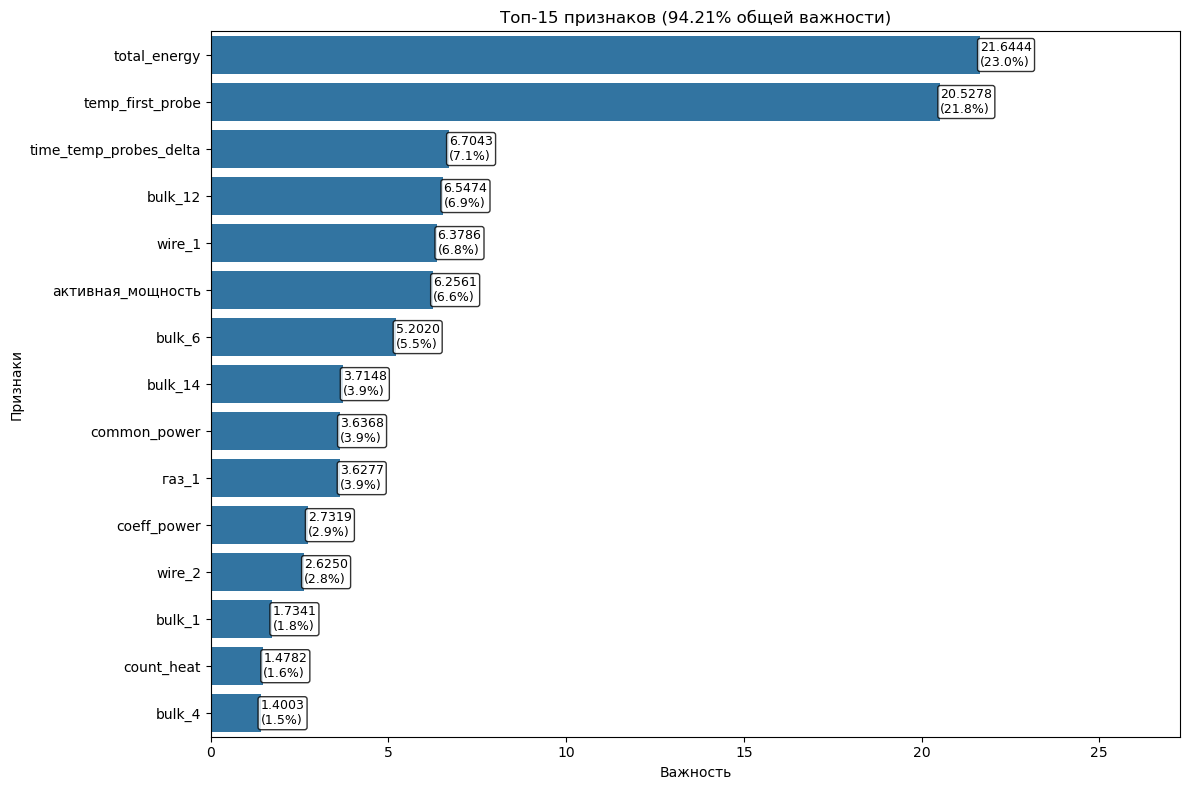

In [206]:
plot_feature_importance_percentage(feature_importance, top_n=15)

Значительное влияние на итоговую температуру оказывают следующие признаки:
* Температура при первом замере
* затраченная энергия.
* разница времени между замерами температуры
* проволочный материал с обозначением **wire_1**
* сыпучий материал с обозначением **bulk_12**




## Итоговый результат

Стояла задача на основании различных параметров в рамках процесса выплавки металла предсказать конечную температуру в ковше.
Были скачены следующие наборы данных:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.

Проведена предварительная обработка данных и исследовательский анализ всех таблиц, сгенерированы ряд новых признаков (таких как длительность нагрева, количество нагревов, общая мощность, затраченная энергия и пр.).

Все наборы данных объеденены в единый набор с групировкой но номеру партии (**key**).

Был выделен целевой признак **temp_last_probe**.

После разделения данных на тренеровочные и тестовые (0.75/0.25) c помощью были проверены несколько простых моделей:
* CatBoostRegressor
* RandomForestRegressor
* ElasticNet

Подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV. Применялась перекрёстная проверка (cross-vaalidation).
Лучшие результаты показала модель CatBoostRegressor показав на тренеровочных данных :
* MAE = 6.288 	

Это ниже границы отбора MAE=6.8. 

Далее была настроена простая нейросеть.
С её помощью были получены следующие значения на тренеровочных данных:
* MAE = 7.450535

Но даже настроенная модель не смогла пройти необходимую границу и получить метрику MAE < 6.8.


Значит лучшею моделью оказалась CatBoostRegressor со значением метрики  MAE = 6.1136.

Значительное влияние на итоговую температуру оказывают следующие признаки:
* Температура при первом замере
* затраченная энергия.
* разница времени между замерами температуры
* проволочный материал с обозначением **wire_1**

Задача выполнена, цель достигнута.